In [2]:
#!pip install numpy matplotlib seaborn scikit-learn scikit-image torch torchvision torchaudio medpy

# 0. Imports et Architecture du modèle

In [3]:
#!pip install importnb

from torch.utils.data import DataLoader
from torchvision import transforms
from progressBar import printProgressBar

import medicalDataLoader
import argparse
from utils import *

from UNet_Base import *
from UNet_Base_steroid import *
from UNet_2_0 import *
from UNet_4_0 import *
from UNet_3_0 import *
from UNet_3_0_attention import *
from UNet_2_0_steroid import *
import random
import torch
import pdb

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from utils_mac import getTargetSegmentation, dice_score

import numpy as np
import torch
import torch.nn.functional as F
from scipy.ndimage import distance_transform_edt as edt
from scipy import ndimage as ndi

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from importnb import Notebook
with Notebook():
    from Mask_Guide import *

import torch.nn as nn
import os
import time
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")


## Architecture du modèle (Basé sur UNet)
En blanc le modèle de base, <span style="color: yellow;">en jaune nos améliorations non terminées,</span> <span style="color: lightgreen;">en vert les améliorations terminées</span>

L’architecture baseline suit la structure classique d’un UNet : *Encoder --> Bottleneck --> Decoder* avec des skip connection skip connections entre blocs symétriques.

### Chemin contractant : Encoder

- On prend en entrée une image à 1 canal et on compresse progressivement les features via 4 blocs encoder :
    - `enc1` : 1 --> 4 canaux
    - `enc2` : 4 --> 8 canaux
    - `enc3` : 8 --> 16 canaux
    - `enc4` : 16 --> 32 canaux (avec dropout pour la régularisation)

- Chaque bloc encoder effectue :
    - une convolution 3×3
    - une normalisation BatchNorm
    - un ReLU
    - <span style="color: yellow;">un dropout optionnel (ajout pour régularisation)</span>
    - un MaxPool pour réduire la résolution spatiale

Ces blocs permettent de capturer progressivement des caractéristiques de plus en plus complexes tout en compressant l’information.

### Bottleneck : Couche centrale

- On arrive au bottleneck (`center`) 32 --> 64 --> 32.

C’est la zone où l’image est représentée de manière la plus compacte avant la reconstruction.

### Bottleneck : Chemin expansif : Decoder

- L’image est ensuite reconstruite via 4 blocs decoder :
    - `dec4` : 64 --> 32 --> 16
    - `dec3` : 32 -6> 16 --> 8
    - `dec2` : 16 --> 8 --> 4
    - `dec1` : 2 convolutions 3*3 (4 --> 4 --> 4) 
 
- Chaque bloc decoder effectue : 
    - une convolution 3×3
    - une normalisation BatchNorm
    - un ReLU
    - un upsampling avec ConvTranspose2d



### Skip Connections

Les sorties des blocs encoder sont concaténées aux blocs decoder correspondants. 
- pour réinjecter des détails locaux provenant de l’encoder, ce qui limite la perte d'information due au bottleneck

### Couche finale

La couche `final` est une convolution 1×1 qui produit C logits pour les C classes --> on obtient un tenseur au format [B, C, H, W]

- B	Taille du batch
- C	Nombre de classes 
- H	Hauteur de l’image
- W	Largeur 

Pour **B** images, pour i allant de 0 à B --> la sortie pour [image i] contient **C** matrices (= une matrice par classe) de dimension **H*W**, avec un logit (=output avant le softmax) pour chaque pixel.

# 1. Définition des fonctions coûts personnalisées

## 1.1 Composantes des loss functions

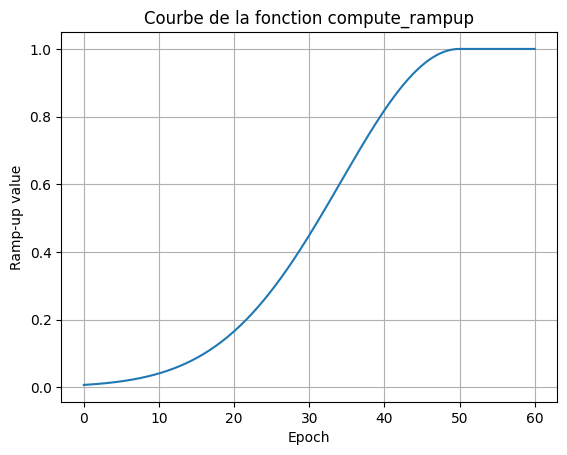

In [4]:
def compute_rampup(epoch, rampup_length=50):
    if epoch < rampup_length:
        phase = 1.0 - epoch / rampup_length
        return float(np.exp(-5.0 * phase * phase))
    else:
        return 1.0

# Génération des points
epochs = np.linspace(0, 60, 300)
values = [compute_rampup(e) for e in epochs]

# Tracé de la courbe
plt.figure()
plt.plot(epochs, values)
plt.xlabel("Epoch")
plt.ylabel("Ramp-up value")
plt.title("Courbe de la fonction compute_rampup")
plt.grid(True)
plt.show()

In [5]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super().__init__()
        self.smooth = smooth
    
    def forward(self, pred, target):
        """
        pred : [B, C, H, W]
        target : [B, H, W] avec labels {0..C-1}
        """
        num_classes = pred.shape[1]

        pred_soft = F.softmax(pred, dim=1)

        # One-hot du target : [B, C, H, W]
        target_onehot = F.one_hot(target, num_classes).permute(0, 3, 1, 2).float()

        intersection = (pred_soft * target_onehot).sum(dim=(0,2,3))
        union = pred_soft.sum(dim=(0,2,3)) + target_onehot.sum(dim=(0,2,3))

        dice = (2 * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1 - dice.mean()

        return dice_loss


In [6]:
def compute_sdf_batch(target_seg, num_classes):
    """
    Compute Signed Distance Map (SDF) for a batch of segmentation maps.

    Parameters
    ----------
    target_seg : torch.Tensor
        Tensor [B, H, W] contenant les classes entières (0..C-1)
    num_classes : int
        Nombre de classes

    Returns
    -------
    torch.Tensor
        SDF tensor [B, C, H, W]
    """
    target_seg = target_seg.cpu().numpy()  # → numpy: [B,H,W]
    B, H, W = target_seg.shape

    sdf_batch = np.zeros((B, num_classes, H, W), dtype=np.float32)

    for b in range(B):
        for c in range(num_classes):

            gt_c = (target_seg[b] == c).astype(np.uint8)

            if gt_c.sum() == 0:
                # Si la classe n'existe pas → SDF = 0 partout
                continue

            # distances à l’extérieur
            negmask = 1 - gt_c
            dist_out = edt(negmask)

            # distances à l’intérieur
            dist_in = edt(gt_c)

            sdf = dist_out - dist_in
            sdf_batch[b, c] = sdf

    return torch.tensor(sdf_batch)


In [7]:
class BoundaryLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, target_sdf):
        """
        pred : [B, C, H, W], logits
        target_sdf : [B, C, H, W], signed distance maps
        """

        pred_probs = F.softmax(pred, dim=1)

        loss = (pred_probs * target_sdf).abs().mean()
        return loss


In [8]:
class TotalVariationLoss(nn.Module):
    def __init__(self, weight=1.0):
        super(TotalVariationLoss, self).__init__()
        self.weight = weight

    def forward(self, x):
        """
        Calcule la variation totale sur les probabilités prédites (Softmax).
        Pénalise les transitions brusques (bruit, trous).
        """
        # x shape: [Batch, Class, H, W]
        # On veut minimiser la différence entre un pixel et ses voisins (droite et bas)
        
        # Différence avec le voisin du bas
        diff_h = torch.abs(x[:, :, 1:, :] - x[:, :, :-1, :])
        # Différence avec le voisin de droite
        diff_w = torch.abs(x[:, :, :, 1:] - x[:, :, :, :-1])
        
        # Moyenne des différences
        loss = torch.mean(diff_h) + torch.mean(diff_w)
        return loss * self.weight

In [9]:
class FocalTverskyLoss(nn.Module):
    def __init__(self, num_classes, alpha=0.7, beta=0.3, gamma=0.75, eps=1e-6):
        super().__init__()
        self.num_classes = num_classes
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.eps = eps

    def forward(self, pred, target):
        # pred : [B, C, H, W]
        # target : [B, H, W]
        pred_soft = torch.softmax(pred, dim=1)

        target_onehot = F.one_hot(target, num_classes=self.num_classes)
        target_onehot = target_onehot.permute(0, 3, 1, 2).float()

        dims = (0, 2, 3)

        tp = torch.sum(pred_soft * target_onehot, dim=dims)
        fp = torch.sum(pred_soft * (1 - target_onehot), dim=dims)
        fn = torch.sum((1 - pred_soft) * target_onehot, dim=dims)

        tversky = (tp + self.eps) / (tp + self.alpha*fp + self.beta*fn + self.eps)
        focal_tversky = torch.pow((1 - tversky), self.gamma)

        return focal_tversky.mean()


In [10]:
class CLDiceLoss(nn.Module):
    """
    CLDice Loss (preseves connectivity)
    """
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def soft_skeletonize(self, prob, iter=3):
        # prob : [B,1,H,W]
        skel = prob
        for _ in range(iter):
            eroded = F.max_pool2d(-prob, kernel_size=3, stride=1, padding=1)
            eroded = -eroded
            temp = F.relu(prob - eroded)
            skel = torch.max(skel, temp)
            prob = eroded
        return skel

    def forward(self, probs, target):
        # probs : [B, C, H, W]
        # target : [B, H, W]
        # Ici on applique au foreground seulement (classe 1 max)
        probs_fg = probs[:, 1:2]  # ajuster si plusieurs classes importantes

        target = target.unsqueeze(1).float()

        skel_pred = self.soft_skeletonize(probs_fg)
        skel_true = self.soft_skeletonize(target)

        tprec = (skel_pred * target).sum() / (skel_pred.sum() + self.smooth)
        tsens = (skel_true * probs_fg).sum() / (skel_true.sum() + self.smooth)

        cldice = 1 - (2 * tprec * tsens) / (tprec + tsens + self.smooth)

        return cldice


## 1.2 Définition des loss functions

**CombinedLoss** :
total_loss = (
    0.6 * ce_loss +
    0.3 * dice_loss +
    0.1 * ramp * boundary_loss
)

In [11]:
class CombinedLoss(nn.Module):
    def __init__(self, num_classes, weight):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(weight=weight)
        self.dice = SoftDiceLoss(num_classes)
        self.boundary = BoundaryLoss()

    def forward(self, pred, target, target_sdf, epoch):
        
        ce_loss = self.ce(pred, target)
        dice_loss = self.dice(pred, target)
        boundary_loss = self.boundary(pred, target_sdf)

        # ramp-up du boundary loss
        ramp = compute_rampup(epoch, rampup_length=50)

        # pondération totale
        total_loss = (
            0.6 * ce_loss +
            0.3 * dice_loss +
            0.1 * ramp * boundary_loss
        )

        return total_loss, ce_loss, dice_loss, boundary_loss, ramp

**CombinedLoss_with_TV** : 

total_loss = (
    0.5 * ce_loss +          
    0.3 * dice_loss +       
    0.1 * ramp * boundary_loss + 
    0.1 * tv_loss           
)

In [12]:
class CombinedLoss_with_TV(nn.Module):
    def __init__(self, num_classes, weight):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(weight=weight)
        self.dice = SoftDiceLoss(num_classes)
        self.boundary = BoundaryLoss()
        self.tv = TotalVariationLoss(weight=1.0)

    def forward(self, pred, target, target_sdf, epoch):
        
        probs = torch.softmax(pred, dim=1)

        ce_loss = self.ce(pred, target)
        dice_loss = self.dice(pred, target)
        boundary_loss = self.boundary(pred, target_sdf)
        tv_loss = self.tv(probs)

        # ramp-up du boundary loss
        ramp = compute_rampup(epoch, rampup_length=40)

        # pondération totale
        total_loss = (
            0.5 * ce_loss +          
            0.3 * dice_loss +       
            0.1 * ramp * boundary_loss + # Contours précis
            0.1 * tv_loss            # Topologie lisse (pas de trous/bruit)
        )

        return total_loss, ce_loss, dice_loss, boundary_loss, ramp, tv_loss

**GuidedCombinedLoss** :
 
total_loss = (
    0.5 * ce_loss +    
    0.3 * dice_loss +                       
    0.1 * ramp_val * boundary_loss +       
    0.1 * tv_loss +                         
    lambda_guide * loss_guide              
)

*Curriculum Learning par la Loss* :

- Le masque agit comme un tuteur pour un arbre : tient le réseau fermement au début quand il est faible, et se relâche doucement pour le laisser tenir tout seul quand il devient fort. 
- relachement sinusoidale 

In [13]:
class GuidedCombinedLoss(nn.Module):
    def __init__(self, num_classes, max_epochs, weight=None, device='cuda'):
        super().__init__()
        self.device = device
        self.max_epochs = max_epochs
        
        # Initialisation des sous-pertes
        self.ce = nn.CrossEntropyLoss(weight=weight)
        self.dice = SoftDiceLoss(num_classes)
        self.boundary = BoundaryLoss()
        self.tv = TotalVariationLoss(weight=1.0)
        self.mse = nn.MSELoss() # Pour comparer Pred vs Guide

    def forward(self, pred, target, guide, target_sdf, epoch):
        """
        pred: Logits [B, C, H, W]
        target: Indices [B, H, W]
        guide: Masque guide aligné (probabiliste) [B, C, H, W]
        target_sdf: Carte de distance [B, C, H, W]
        epoch: Entier (epoch actuelle)
        """
        # 1. Calcul des probabilités (Softmax) pour Dice, TV, Boundary et Guide
        probs = F.softmax(pred, dim=1)
        
        # 2. Calcul des pertes "classiques"
        ce_loss = self.ce(pred, target)
        dice_loss = self.dice(pred, target)
        
        # Boundary Loss avec Ramp-up (monte en puissance progressivement)
        boundary_loss = self.boundary(probs, target_sdf)
        ramp_val = compute_rampup(epoch, rampup_length=20) # Ramp-up sur 20 epochs
        
        # TV Loss (lissage constant)
        tv_loss = self.tv(probs)

        # 3. Calcul du Guide Loss (Dynamique Cosinus)
        # Formule : lambda décroît de 0.2 à 0.0 suivant une courbe cosinus
        # On limite epoch à max_epochs pour éviter de repartir en négatif ou remonter
        curr_epoch_clamped = min(epoch, self.max_epochs)
        
        lambda_guide = 0.2 * 0.5 * (1 + math.cos(math.pi * curr_epoch_clamped / self.max_epochs))
        
        # Loss MSE entre la prédiction du réseau et le masque guide approximatif
        loss_guide = self.mse(probs, guide)

        # 4. Somme pondérée finale
        total_loss = (
            0.5 * ce_loss +                         # Base solide (classification)
            0.3 * dice_loss +                       # Cohérence régionale (GT)
            0.1 * ramp_val * boundary_loss +        # Précision contours (Fin)
            0.1 * tv_loss +                         # Lissage / Débruitage (Constant)
            lambda_guide * loss_guide               # Tuteur (Début -> Disparition)
        )

        return total_loss, ce_loss, dice_loss, boundary_loss, ramp_val, tv_loss, loss_guide, lambda_guide

Loss function pour fine tuning

**FineTuningLoss**

total = (
    0.45 * ftl_loss +
    0.30 * boundary_weight * boundary_loss +
    0.20 * cldice_loss +
    0.05 * tv_loss
)

In [14]:
class FineTuningLoss(nn.Module):
    """
    Loss de compétition : Focal-Tversky + Boundary + CLDice + TV
    Adaptée pour fine-tuning de modèle haut niveau.
    """
    def __init__(self, num_classes, alpha=0.7, beta=0.3, gamma=0.75):
        super().__init__()
        self.ftl = FocalTverskyLoss(num_classes, alpha=alpha, beta=beta, gamma=gamma)
        self.boundary = BoundaryLoss()
        self.cldice = CLDiceLoss()  
        self.tv = TotalVariationLoss(weight=0.1)

    def forward(self, pred, target, target_sdf, epoch):

        probs = torch.softmax(pred, dim=1)

        # losses composantes
        ftl_loss = self.ftl(pred, target)  
        boundary_loss = self.boundary(pred, target_sdf)
        cldice_loss = self.cldice(probs, target)
        tv_loss = self.tv(probs)

        # ramp-up court : on active rapidement la loss contour
        boundary_weight = compute_rampup(epoch, rampup_length=15)

        # combinaison optimale
        total = (
            0.45 * ftl_loss +
            0.30 * boundary_weight * boundary_loss +
            0.20 * cldice_loss +
            0.05 * tv_loss
        )

        return total, ftl_loss, boundary_loss, cldice_loss, tv_loss


## 1.3. Autre fonction loss pour le fine-tuning

In [ ]:
class AdaptiveClassWeightedCombinedLoss(nn.Module):
    def __init__(self, num_classes=4,
                 weight=None,
                 alpha=2.0, decay=0.9, # Alpha augmenté pour punir plus fort les erreurs
                 w_dice=1.0, w_asd=0.2, w_hd=0.2, w_focal=0.5):
        super().__init__()
        self.num_classes = num_classes
        if weight is None:
            self.base_class_weights = torch.ones(num_classes)
        else:
            self.base_class_weights = torch.tensor(weight, dtype=torch.float32)

        self.alpha = alpha
        self.decay = decay

        # EMA of per-class dice (start high to avoid shock)
        self.register_buffer('ema_dice', torch.full((num_classes,), 0.90))

        # Sous-fonctions de perte
        self.dice_loss_fn = SoftDiceLoss(num_classes) # Supposée exister
        self.boundary_loss_fn = BoundaryLoss()        # Supposée exister
        self.ce_loss_fn = nn.CrossEntropyLoss()       # Focal peut être remplacé par CE pondérée si besoin
        
        self.w_dice = w_dice
        self.w_asd = w_asd # Utilisé pour pondérer la boundary loss globale
        self.w_hd = w_hd   # (Souvent BoundaryLoss approxime ASD/HD)
        self.w_focal = w_focal

    def forward(self, logits, target, target_sdf, epoch=0):
        """
        logits: [B, C, H, W]
        target: [B, H, W] (Indices)
        target_sdf: [B, C, H, W] (Distance Maps pré-calculées)
        """
        device = logits.device
        
        # 1. Calcul des métriques pour l'adaptation (Dice sans gradient)
        with torch.no_grad():
            preds_softmax = torch.softmax(logits, dim=1)
            current_dices = []
            for c in range(self.num_classes):
                p_c = preds_softmax[:, c]
                t_c = (target == c).float()
                inter = (p_c * t_c).sum()
                union = p_c.sum() + t_c.sum()
                d_c = (2. * inter + 1e-5) / (union + 1e-5)
                current_dices.append(d_c.mean().item())
            
            # Mise à jour EMA
            cur = torch.tensor(current_dices, device=device)
            self.ema_dice = self.decay * self.ema_dice + (1.0 - self.decay) * cur

        # 2. Calcul des poids adaptatifs
        # Si le Dice est bas, le poids augmente
        adaptive_factor = 1.0 + self.alpha * (1.0 - self.ema_dice)
        final_weights = self.base_class_weights.to(device) * adaptive_factor
        
        # Normalisation des poids pour éviter l'explosion de la loss
        final_weights = final_weights / final_weights.mean()

        # 3. Calcul des Losses
        
        # A. Cross Entropy / Focal (Pondérée par nos poids adaptatifs)
        # On recrée une CE avec les nouveaux poids à la volée
        ce_adapt = nn.CrossEntropyLoss(weight=final_weights)(logits, target)
        
        # B. Dice Loss (Multiclass)
        # On peut pondérer chaque classe dans le Dice aussi
        dice_loss = 0.0
        preds_softmax = torch.softmax(logits, dim=1)
        for c in range(self.num_classes):
            p_c = preds_softmax[:, c]
            t_c = (target == c).float()
            inter = (p_c * t_c).sum()
            union = p_c.sum() + t_c.sum() + 1e-5
            d_loss = 1.0 - (2. * inter / union)
            dice_loss += d_loss * final_weights[c]
        dice_loss /= self.num_classes

        # C. Boundary Loss (Utilise le SDF fourni)
        # BoundaryLoss gère généralement le multiclasse en interne ou on boucle
        # Ici on suppose une implémentation standard qui prend [B, C, H, W] et [B, C, H, W]
        bound_loss = self.boundary_loss_fn(preds_softmax, target_sdf) 

        # 4. Combinaison
        total_loss = (self.w_dice * dice_loss + 
                      self.w_focal * ce_adapt + 
                      (self.w_asd + self.w_hd) * bound_loss) # On regroupe ASD/HD sous Boundary

        return total_loss, ce_adapt, dice_loss, bound_loss, self.ema_dice

# 2. Définition des métriques

## 2.1 Dice

In [16]:
def dice_score(pred, target, num_classes, eps=1e-7):
    """
    Calcule le Dice score pour chaque classe

    Parameters
    ----------
    pred : voir le markdown plus haut
    target : format [B, H, W]
        contient une seule valeur (et une seule matrice) par pixel :
        (0=classe 0, 1=classe 1, 2=classe 2, 3=classe 3)
    num_classes : int
        nombre de classes - incluant le background
    eps : float
        petite valeur pour éviter la division par zéro

    Returns
    -------
    dice_per_class : tensor
        tensor contenant le dice score pour chaque classe (dim [num_classes])
    """
    pred_classes = torch.argmax(pred, dim=1)  # retourne une pred par pixel au format [B, H, W]

    dice_per_class = []
    # on itere sur toutes les classes pour
    for c in range(num_classes):
        # création de masques binaires pour la classe c pour pred et target
        pred_c = (pred_classes == c).float()
        target_c = (target == c).float() 

        intersection = (pred_c * target_c).sum() # ne donne 1 que si la prédition et  la target correspondent
        union = pred_c.sum() + target_c.sum() # la somme des pixels prédits + la somme des pixels réels

        dice = (2 * intersection + eps) / (union + eps)
        dice_per_class.append(dice)

    # retoune un tensor de dimension [num_classes]
    return torch.stack(dice_per_class)

## 2.2 Average Surface Distance (ASD)

In [17]:
def get_boundary(mask):
    """
    Extrait les pixels de frontière du masque (binaire).
    """
    mask = mask.astype(np.uint8)
    # Convolution Laplacienne pour obtenir les bords
    lap = ndi.laplace(mask)
    boundary = np.logical_and(mask == 1, lap != 0)
    return boundary


In [18]:
def asd_per_class(pred, gt):
    """
    Calcule l'Average Surface Distance (ASD) entre deux masques binaires.

    pred : ndarray (H, W) 
        Masque prédiction (0 ou 1)
    gt : ndarray (H, W) 
        Masque ground-truth (0 ou 1)

    Returns
    -------
    float
        ASD (Average Surface Distance)
    """

    pred = pred.astype(np.uint8)
    gt = gt.astype(np.uint8)

    # Extraire frontières
    pred_b = get_boundary(pred)
    gt_b = get_boundary(gt)

    # Gestion du cas vide
    if pred_b.sum() == 0 or gt_b.sum() == 0:
        return np.nan

    # Distance transform sur GT
    dt_gt = ndi.distance_transform_edt(~gt_b)
    d_pred_to_gt = dt_gt[pred_b]

    # Distance transform sur PRED
    dt_pred = ndi.distance_transform_edt(~pred_b)
    d_gt_to_pred = dt_pred[gt_b]

    # ASD = moyenne bidirectionnelle
    return (d_pred_to_gt.mean() + d_gt_to_pred.mean()) / 2.0


## 2.3 hausdorff_distance (HD)

In [19]:
def hausdorff_distance_per_class(pred, gt):
    """
    Calcule la distance de Hausdorff entre deux masques binaires.

    pred : ndarray (H, W)
    gt : ndarray (H, W)

    Returns
    -------
    float
        Distance de Hausdorff (pixels)
    """

    pred = pred.astype(np.uint8)
    gt = gt.astype(np.uint8)

    pred_b = get_boundary(pred)
    gt_b = get_boundary(gt)

    if pred_b.sum() == 0 or gt_b.sum() == 0:
        return np.nan

    dt_gt = ndi.distance_transform_edt(~gt_b)
    dt_pred = ndi.distance_transform_edt(~pred_b)

    dist_pred_to_gt = dt_gt[pred_b]
    dist_gt_to_pred = dt_pred[gt_b]

    # Hausdorff = max des distances bidirectionnelles
    hd = max(dist_pred_to_gt.max(), dist_gt_to_pred.max())
    return hd


## 2.4 metrics_multiclass()
Calcule DICE, ASD et HD par classe


In [20]:
def metrics_multiclass(pred, gt, num_classes):
    """
    Calcule DICE, ASD et HD par classe.

    pred : ndarray [H, W] valeurs {0..num_classes-1}
    gt   : ndarray [H, W]

    Returns
    -------
    dict
        {
            "dice": [c1, c2, ...],
            "asd":  [c1, c2, ...],
            "hd":   [c1, c2, ...]
        }
    """

    dice_scores = []
    asd_scores = []
    hd_scores = []

    for c in range(num_classes):
        pred_c = (pred == c).astype(np.uint8)
        gt_c   = (gt == c).astype(np.uint8)

        # DICE déjà existant dans ton code :
        intersection = (pred_c & gt_c).sum()
        denom = pred_c.sum() + gt_c.sum()
        dice = (2 * intersection / denom) if denom > 0 else np.nan

        asd = asd_per_class(pred_c, gt_c)
        hd  = hausdorff_distance_per_class(pred_c, gt_c)

        dice_scores.append(dice)
        asd_scores.append(asd)
        hd_scores.append(hd)

    return {
        "dice": np.array(dice_scores),
        "asd":  np.array(asd_scores),
        "hd":   np.array(hd_scores)
    }


# 3. Validation

## 3.1 Fonctions utiles

In [21]:
def compute_sdf(mask):
    if mask.sum() == 0:
        return np.zeros_like(mask, dtype=np.float32)
    negmask = 1 - mask
    dist_out = edt(negmask)   # distance to foreground from outside
    dist_in  = edt(mask)      # distance to background from inside
    sdf = dist_out - dist_in
    return sdf.astype(np.float32)

# def compute_sdf(mask):
#     """Calcule la fonction de distance signée (SDF) pour un masque binaire."""
#     mask = mask.astype(np.bool_)

#     if mask.sum() == 0:
#         return np.zeros_like(mask, dtype=np.float32)

#     dist_in  = edt(mask)
#     dist_out = edt(~mask)
    
#     sdf = dist_in - dist_out
#     return sdf

# La meme fonction etait présente deux fois dans le code, laissée une seule fois.

In [22]:
# --- helper: compute SDF batch [B, C, H, W] from segmentation_classes [B, H, W] ---
def compute_sdf_batch_gpu(segmentation_classes, num_classes, device):
    seg_np = segmentation_classes.cpu().numpy()
    B, H, W = seg_np.shape
    sdf_batch = np.zeros((B, num_classes, H, W), dtype=np.float32)
    for b in range(B):
        for c in range(num_classes):
            bin_mask = (seg_np[b] == c).astype(np.uint8)
            if bin_mask.sum() == 0:
                sdf_batch[b, c] = np.zeros((H, W), dtype=np.float32)
            else:
                sdf_batch[b, c] = compute_sdf(bin_mask)
    return torch.from_numpy(sdf_batch).float().to(device)

In [23]:
def get_loss_components_by_name(rest_components):
    """
    Déballe les composants de perte auxiliaires dans un dictionnaire.
    Les valeurs manquantes sont remplacées par 0.0.
    
    Args:
        rest_components (list/tuple): Attendu [TV_Loss, Guide_Loss, Lambda_Guide, Ramp_Val]
        
    Returns:
        dict: {'tv_loss': val, 'loss_guide': val, 'lambda_guide': val, 'ramp_val': val}
    """
    
    # Initialisation sécurisée de tous les termes que *rest pourrait contenir
    components = {
        'tv_loss': 0.0,
        'loss_guide': 0.0,
        'lambda_guide': 0.0,
    }
    
    n_found = len(rest_components)

    # Affectation des valeurs trouvées, l'ordre est critique :
    if n_found >= 1:
        components['tv_loss'] = rest_components[0]
    if n_found >= 2:
        components['loss_guide'] = rest_components[1]
    if n_found >= 3:
        components['lambda_guide'] = rest_components[2]
        
    return components

In [24]:
def dice_per_class_logits(pred_logits, target, num_classes, eps=1e-6):
    # pred_logits: tensor [B,C,H,W], target: [B,H,W]
    pred = torch.argmax(pred_logits, dim=1)  # [B,H,W]
    B = pred.shape[0]
    out = []
    for c in range(num_classes):
        dices = []
        for b in range(B):
            pred_c = (pred[b] == c).float()
            tgt_c = (target[b] == c).float()
            inter = (pred_c * tgt_c).sum()
            denom = pred_c.sum() + tgt_c.sum()
            dice = ((2.0 * inter + eps) / (denom + eps)).item() if denom.item() > 0 else 0.0
            dices.append(dice)
        out.append(np.mean(dices))
    return np.array(out)  # shape (num_classes,)

In [25]:
def hd95_from_distances(distances):
    """ distances: array of distances to contour points (e.g. output of surface distance).
        On renvoie le 95ème percentile, comme dans les challenges MSD/BRATS. 
    """
    distances = np.asarray(distances)
    if distances.size == 0:
        return np.nan
    return np.percentile(distances, 95)

In [26]:
def extract_logits(x):
    """
    Certains modèles renvoient un tuple (logits, extra).
    On s’assure ici de toujours récupérer un tenseur [B,C,H,W].
    """
    if isinstance(x, tuple) or isinstance(x, list):
        return x[0]
    return x

## 3.2 Définition des fonctions de validation

### 3.2.1 validate_simple() 


In [27]:
def validate_simple(
    model,
    loader,
    ce_loss_fn,
    num_classes,
    device,
    n_images=3,
    show_graphics=True, # Ce paramètre contrôle maintenant si l'on affiche les graphiques ou non
    show_sdf_graphics=False,
    save_dir=None
):
    model.eval()
    total_loss = 0.0
    dice_accum = []
    metrics_accum = []


    cmap = "jet"
    class_colors = plt.cm.get_cmap(cmap, num_classes)

    class_names = ["Backgrond", "Endocarde du ventricule gauche (RV)", "Mycarde du ventricule gauche (Myo)","Endocarde du ventricule gauche (LV)"]  # taille = num_classes

    legend_patches = [
        mpatches.Patch(color=class_colors(i), label=class_names[i])
        for i in range(num_classes)
    ]

    example_count = 0

    with torch.no_grad():
        for images, labels, _ in loader:

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images) 
            outputs = extract_logits(outputs)                        # logits [B,C,H,W]
            # Assurez-vous que getTargetSegmentation est importé
            segmentation_classes = getTargetSegmentation(labels)             # GT classes [B,H,W]

            loss_ce = ce_loss_fn(outputs, segmentation_classes) # Utilisation de la CE pondérée pour la validation
            total_loss += loss_ce.item()

            dice_epoch = dice_score(outputs, segmentation_classes, num_classes) # Assurez-vous que dice_score est importé
            dice_accum.append(dice_epoch.detach().cpu().numpy())

            preds = torch.argmax(outputs, dim=1)            # [B,H,W]

            preds_np = preds.cpu().numpy()
            gts_np   = segmentation_classes.cpu().numpy()
            imgs_np  = images[:,0].cpu().numpy()

            # ---------- Accumulation metrics ----------
            # Assurez-vous que metrics_multiclass est importé
            for b in range(preds_np.shape[0]):
                m = metrics_multiclass(preds_np[b], gts_np[b], num_classes) 
                metrics_accum.append(m)

            # ---------- Visualisation (Contrôlée par 'show') ----------
            if show_graphics and example_count < n_images:
                batch_size = preds_np.shape[0]
                to_show = min(batch_size, n_images - example_count)

                for i in range(to_show):
                    img  = imgs_np[i]
                    gt   = gts_np[i]
                    pred = preds_np[i]

                    # 1. Afficher l'image, la GT et la prédiction multi-classes (pour contexte)
                    fig_main, axs_main = plt.subplots(1, 4, figsize=(16, 4))


                    factor = 1.5  # >1 = contraste plus fort, <1 = contraste plus faible
                    mean = img.mean()
                    img_contrast = np.clip((img - mean) * factor + mean, 0, 1)

                    brightness = 0.5  # ajouter une valeur positive pour éclaircir
                    img_final = np.clip(img_contrast + brightness, 0, 1)


                    axs_main[0].imshow(img_final, cmap="gray")
                    axs_main[0].set_title("Image")
                    axs_main[0].axis("off")

                    axs_main[1].imshow(gt, cmap=cmap, vmin=0, vmax=num_classes-1)
                    axs_main[1].set_title("Mask GT")
                    axs_main[1].axis("off")

                    axs_main[2].imshow(pred, cmap=cmap, vmin=0, vmax=num_classes-1)
                    axs_main[2].set_title("Prédiction")
                    axs_main[2].axis("off")


                    axs_main[3].imshow(img_final, cmap="gray")
                    axs_main[3].imshow(pred, cmap=cmap, alpha=0.45, vmin=0, vmax=num_classes-1)
                    axs_main[3].set_title("Overlay")
                    axs_main[3].axis("off")

                    # Ajuster l'espace pour que la légende ne chevauche pas les sous-graphes
                    fig_main.tight_layout(rect=[0, 0.1, 1, 1])  # laisse un espace en bas pour la légende

                    # Ajouter la légende de figure
                    fig_main.legend(handles=legend_patches,
                                    loc="lower center",
                                    ncol=num_classes,
                                    bbox_to_anchor=(0.5, 0.05))  # position ajustée sous les sous-graphes

                    plt.tight_layout()
                    plt.show()


                    if save_dir is not None:
                         os.makedirs(save_dir, exist_ok=True)
                         plt.savefig(
                             f"{save_dir}/epoch_image_{example_count}_multiclass.png",
                             dpi=150
                         )
                    
                    if show_graphics: plt.show()
                    plt.close(fig_main)
                    if show_sdf_graphics:
                        # 2. Visualisation des SDF pour chaque classe de premier plan (1, 2, ..., num_classes-1)
                        # Nous supposons que la classe 0 est le background
                        for c in range(1, num_classes):
                            # Création des masques binaires pour la classe c
                            mask_gt_c = (gt == c)
                            mask_pred_c = (pred == c)

                            # Calcul des SDF
                            sdf_gt_c = compute_sdf(mask_gt_c)
                            sdf_pred_c = compute_sdf(mask_pred_c)

                            # Calul de l'Erreur SDF (|SDF_GT - SDF_Pred|)
                            sdf_error_c = np.abs(sdf_gt_c - sdf_pred_c)

                            # Crée une figure avec les 4 graphiques SDF
                            fig_sdf, axs_sdf = plt.subplots(1, 4, figsize=(20, 5))

                            # Graphiques
                            axs_sdf[0].imshow(img, cmap="gray")
                            axs_sdf[0].contour(mask_gt_c, colors='red', linewidths=1.5)
                            axs_sdf[0].set_title(f"Image et Bordure GT (Cl. {c})")
                            axs_sdf[0].axis("off")

                            axs_sdf[1].imshow(sdf_gt_c, cmap="seismic")
                            axs_sdf[1].set_title(f"SDF GT (Cl. {c})")
                            axs_sdf[1].axis("off")

                            axs_sdf[2].imshow(sdf_pred_c, cmap="seismic")
                            axs_sdf[2].set_title(f"SDF Pred (Cl. {c})")
                            axs_sdf[2].axis("off")

                            axs_sdf[3].imshow(sdf_error_c, cmap="viridis")
                            axs_sdf[3].set_title(f"Erreur SDF |GT-Pred| (Cl. {c})")
                            axs_sdf[3].axis("off")

                            plt.tight_layout()

                            # if save_dir is not None:
                            #     os.makedirs(save_dir, exist_ok=True)
                            #     plt.savefig(
                            #         f"{save_dir}/epoch_image_{example_count}_sdf_class_{c}.png",
                            #         dpi=150
                            #     )
                            
                            if show_sdf_graphics: plt.show()
                            plt.close(fig_sdf)

                    example_count += 1
            
            # Condition pour sortir de la boucle des lots après n_images, si show=True
            if show_graphics and example_count >= n_images:
                 break


# Aggregation
    dice_mean = np.mean(np.stack(dice_accum), axis=0) if dice_accum else np.zeros(num_classes)

    if len(metrics_accum) > 0:
        all_dice = np.stack([m["dice"] for m in metrics_accum], axis=0)
        all_asd  = np.stack([m["asd"]  for m in metrics_accum], axis=0)
        all_hd   = np.stack([m["hd"]   for m in metrics_accum], axis=0)
        
        # HD95 = percentile 95 de toutes les distances "hd" (dans ton code hd = distance par classe)
        all_hd95 = np.array([hd95_from_distances(h) for h in all_hd.T]).T
        mean_hd95 = np.nanmean(all_hd95, axis=0)

        agg = {
            "dice": np.nanmean(all_dice, axis=0),
            "asd" : np.nanmean(all_asd , axis=0),
            "hd"  : np.nanmean(all_hd  , axis=0),
            "hd95": mean_hd95
        }

            # --- Composite Score (Dice + HD95) ---
            
        dice_macro = np.nanmean(agg["dice"])
        hd95_macro = np.nanmean(agg["hd95"])

        hd95_score = 1.0 / (1.0 + hd95_macro)
        composite_score = 0.5 * dice_macro + 0.5 * hd95_score

        agg["dice_macro"] = dice_macro
        agg["hd95_macro"] = hd95_macro
        agg["composite"] = composite_score

    return total_loss / max(1, len(loader)), dice_mean, agg

### 3.2.2 validate_guided() 
A utiliser pour un training impliquant les masques guides

In [28]:
def validate_guided(
    model, 
    loader, 
    locator, 
    guide_tensor, 
    ce_loss_fn, 
    num_classes, 
    device, 
    n_images=3, 
    show_graphics=True, 
    show_sdf_graphics=False, 
    save_dir=None,
    att_guide=False
):
    model.eval()
    total_loss = 0.0
    dice_accum = []
    metrics_accum = []
    example_count = 0

    cmap = "jet"
    class_colors = plt.cm.get_cmap(cmap, num_classes)

    class_names = ["Backgrond", "Endocarde du ventricule gauche (RV)", "Mycarde du ventricule gauche (Myo)","Endocarde du ventricule gauche (LV)"]  # taille = num_classes

    legend_patches = [
        mpatches.Patch(color=class_colors(i), label=class_names[i])
        for i in range(num_classes)
    ]

    with torch.no_grad():
        for images, labels, _ in loader:
            images = images.to(device)
            labels = labels.to(device)

            # --- A. GUIDAGE ---
            offsets = locator(images)
            H, W = images.shape[2], images.shape[3]
            aligned_guides = shift_batch_on_gpu(guide_tensor, offsets, H, W)
            
            # --- B. FUSION ---
            inputs = torch.cat([images, aligned_guides], dim=1)

            # --- C. PRÉDICTION ---
            if att_guide:
                output = model(images, masks=aligned_guides)
            else:
                output = model(inputs)

            outputs = extract_logits(output) 
            
            # --- SUITE CLASSIQUE ---
            segmentation_classes = getTargetSegmentation(labels).to(device)
            loss_ce = ce_loss_fn(outputs, segmentation_classes)
            total_loss += loss_ce.item()

            
            dice_epoch = dice_score(outputs, segmentation_classes, num_classes)
            dice_accum.append(dice_epoch)

            preds = torch.argmax(outputs, dim=1)
            
            # Conversion Numpy pour affichage
            preds_np = preds.cpu().numpy()
            gts_np   = segmentation_classes.cpu().numpy()
            imgs_np  = images[:,0].cpu().numpy()
            # On récupère aussi le guide aligné pour l'affichage (on prend le canal VG: index 3)
            guides_vg = aligned_guides[:, 3].cpu().numpy() 
            guides_bg = aligned_guides[:, 0].cpu().numpy() 
            guides_rv = aligned_guides[:, 1].cpu().numpy() 
            guides_myo = aligned_guides[:, 2].cpu().numpy() 

            # Accumulation metrics
            for b in range(preds_np.shape[0]):
                m = metrics_multiclass(preds_np[b], gts_np[b], num_classes) 
                metrics_accum.append(m)

            # --- VISUALISATION ---
            if (show_graphics or save_dir) and example_count < n_images:
                batch_size = preds_np.shape[0]
                to_show = min(batch_size, n_images - example_count)

                for i in range(to_show):
                    img  = imgs_np[i]
                    gt   = gts_np[i]
                    pred = preds_np[i]
                    guide_vg = guides_vg[i] # Le guide du VG aligné sur cette image
                    # guide_bg = guides_bg[i]
                    # guide_rv = guides_rv[i]
                    # guide_myo = guides_myo[i]

                    if show_graphics:
                        
                        factor = 1.5  # >1 = contraste plus fort, <1 = contraste plus faible
                        mean = img.mean()
                        img_contrast = np.clip((img - mean) * factor + mean, 0, 1)

                        brightness = 0.5  # ajouter une valeur positive pour éclaircir
                        img_final = np.clip(img_contrast + brightness, 0, 1)


                        # On crée 4 sous-graphiques au lieu de 3
                        fig, axs = plt.subplots(1, 5, figsize=(20, 4))
                        
                        # 1. Image Originale
                        axs[0].imshow(img_final, cmap="gray")
                        axs[0].set_title("Input")
                        axs[0].axis('off')

                        # 2. SUPERPOSITION (Image + Guide VG)
                        axs[1].imshow(img_final, cmap="gray")
                        # Alpha blending pour voir l'image dessous
                        axs[1].imshow(guide_vg, cmap="jet", alpha=0.4, vmin=0, vmax=1) 
                        axs[1].set_title("Guide Aligné (VG)")
                        axs[1].axis('off')

                        # 3. Vérité Terrain
                        axs[2].imshow(gt, cmap="jet", vmin=0, vmax=num_classes-1)
                        axs[2].set_title("Ground Truth")
                        axs[2].axis('off')

                        # 4. Prédiction du modèle
                        axs[3].imshow(pred, cmap="jet", vmin=0, vmax=num_classes-1)
                        axs[3].set_title("Prédiction")
                        axs[3].axis('off')

                        # 5. Overlay Prédiction
                        axs[4].imshow(img_final, cmap="gray")
                        axs[4].imshow(pred, cmap=cmap, alpha=0.45, vmin=0, vmax=num_classes-1)
                        axs[4].set_title("Overlay")
                        axs[4].axis("off")



                        plt.tight_layout()
                        plt.show()
                        plt.close()
                    
                    example_count += 1
            
            if example_count >= n_images: break

    # Aggregation
    dice_mean = np.mean(np.stack(dice_accum), axis=0) if dice_accum else np.zeros(num_classes)

    if len(metrics_accum) > 0:
        all_dice = np.stack([m["dice"] for m in metrics_accum], axis=0)
        all_asd  = np.stack([m["asd"]  for m in metrics_accum], axis=0)
        all_hd   = np.stack([m["hd"]   for m in metrics_accum], axis=0)
        
        # HD95 = percentile 95 de toutes les distances "hd" (dans ton code hd = distance par classe)
        all_hd95 = np.array([hd95_from_distances(h) for h in all_hd.T]).T
        mean_hd95 = np.nanmean(all_hd95, axis=0)

        agg = {
            "dice": np.nanmean(all_dice, axis=0),
            "asd" : np.nanmean(all_asd , axis=0),
            "hd"  : np.nanmean(all_hd  , axis=0),
            "hd95": mean_hd95
        }

            # --- Composite Score (Dice + HD95) ---
            
        dice_macro = np.nanmean(agg["dice"])
        hd95_macro = np.nanmean(agg["hd95"])

        hd95_score = 1.0 / (1.0 + hd95_macro)
        composite_score = 0.5 * dice_macro + 0.5 * hd95_score

        agg["dice_macro"] = dice_macro
        agg["hd95_macro"] = hd95_macro
        agg["composite"] = composite_score

    return total_loss / max(1, len(loader)), dice_mean, agg

### 3.2.3 validate_guided_attention

In [29]:
def validate_guided_attention(
    model, 
    loader, 
    locator, 
    guide_tensor, 
    ce_loss_fn, 
    num_classes, 
    device, 
    n_images=3, 
    show_graphics=True, 
    show_sdf_graphics=False, 
    save_dir=None
):
    model.eval()
    total_loss = 0.0
    dice_accum = []
    metrics_accum = []
    example_count = 0

    cmap = "jet"
    class_colors = plt.cm.get_cmap(cmap, num_classes)

    class_names = [
        "Background",
        "Endocarde RV",
        "Myocarde",
        "Endocarde LV"
    ]

    legend_patches = [
        mpatches.Patch(color=class_colors(i), label=class_names[i])
        for i in range(num_classes)
    ]

    with torch.no_grad():
        for images, labels, _ in loader:
            images = images.to(device)
            labels = labels.to(device)

            # ---- A. GUIDAGE ----
            offsets = locator(images)
            H, W = images.shape[2], images.shape[3]
            aligned_guides = shift_batch_on_gpu(guide_tensor, offsets, H, W)

            # ---- B. PREDICTION ----
            output = model(images, aligned_guides)

            # ---- C. LOSS + DICE ----
            segmentation_classes = getTargetSegmentation(labels).to(device)
            loss_ce = ce_loss_fn(outputs, segmentation_classes)
            total_loss += loss_ce.item()

            dice_epoch = dice_score(outputs, segmentation_classes, num_classes)
            dice_accum.append(dice_epoch)

            preds = torch.argmax(outputs, dim=1)

            preds_np = preds.cpu().numpy()
            gts_np   = segmentation_classes.cpu().numpy()
            imgs_np  = images[:,0].cpu().numpy()

            guides_vg = aligned_guides[:, 3].cpu().numpy()

            # ---- Metrics ----
            for b in range(preds_np.shape[0]):
                m = metrics_multiclass(preds_np[b], gts_np[b], num_classes)
                metrics_accum.append(m)

            # ---- VISUALISATION ----
            if (show_graphics or save_dir) and example_count < n_images:
                batch_size = preds_np.shape[0]
                to_show = min(batch_size, n_images - example_count)

                for i in range(to_show):
                    img  = imgs_np[i]
                    gt   = gts_np[i]
                    pred = preds_np[i]
                    guide_vg = guides_vg[i]

                    if show_graphics:
                        factor = 1.5
                        mean = img.mean()
                        img_contrast = np.clip((img - mean) * factor + mean, 0, 1)
                        brightness = 0.5
                        img_final = np.clip(img_contrast + brightness, 0, 1)

                        fig, axs = plt.subplots(1, 5, figsize=(20, 4))

                        axs[0].imshow(img_final, cmap="gray")
                        axs[0].set_title("Input")
                        axs[0].axis('off')

                        axs[1].imshow(img_final, cmap="gray")
                        axs[1].imshow(guide_vg, cmap="jet", alpha=0.4)
                        axs[1].set_title("Guide Aligné (VG)")
                        axs[1].axis('off')

                        axs[2].imshow(gt, cmap="jet", vmin=0, vmax=num_classes-1)
                        axs[2].set_title("GT")
                        axs[2].axis('off')

                        axs[3].imshow(pred, cmap="jet", vmin=0, vmax=num_classes-1)
                        axs[3].set_title("Prediction")
                        axs[3].axis('off')

                        axs[4].imshow(img_final, cmap="gray")
                        axs[4].imshow(pred, cmap="jet", alpha=0.45, vmin=0, vmax=num_classes-1)
                        axs[4].set_title("Overlay")
                        axs[4].axis("off")

                        plt.tight_layout()
                        plt.show()
                        plt.close()

                    example_count += 1

            if example_count >= n_images:
                break

    # Aggregation
    dice_mean = np.mean(np.stack(dice_accum), axis=0) if dice_accum else np.zeros(num_classes)

    if len(metrics_accum) > 0:
        all_dice = np.stack([m["dice"] for m in metrics_accum], axis=0)
        all_asd  = np.stack([m["asd"]  for m in metrics_accum], axis=0)
        all_hd   = np.stack([m["hd"]   for m in metrics_accum], axis=0)
        
        # HD95 = percentile 95 de toutes les distances "hd" (dans ton code hd = distance par classe)
        all_hd95 = np.array([hd95_from_distances(h) for h in all_hd.T]).T
        mean_hd95 = np.nanmean(all_hd95, axis=0)

        agg = {
            "dice": np.nanmean(all_dice, axis=0),
            "asd" : np.nanmean(all_asd , axis=0),
            "hd"  : np.nanmean(all_hd  , axis=0),
            "hd95": mean_hd95
        }

            # --- Composite Score (Dice + HD95) ---
            
        dice_macro = np.nanmean(agg["dice"])
        hd95_macro = np.nanmean(agg["hd95"])

        hd95_score = 1.0 / (1.0 + hd95_macro)
        composite_score = 0.5 * dice_macro + 0.5 * hd95_score

        agg["dice_macro"] = dice_macro
        agg["hd95_macro"] = hd95_macro
        agg["composite"] = composite_score

    return total_loss / max(1, len(loader)), dice_mean, agg


# 4. Entrainement

## 4.1 runTraining()
Fonction d'origine : ne plus utiliser, gardée pour debugage

In [30]:
def runTraining(model_class):

    print('-' * 40)
    print('~~~~~~~~  Starting the training (Standard Loss) ~~~~~~')
    print('-' * 40)

    # 1. Détection du Device
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device utilisé : {device}")

    ## HYPERPARAMETERS
    batch_size = 4
    batch_size_val = 4 
    lr = 0.001    
    epoch = 50 
    
    root_dir = './Data/'

    ## DATASETS & LOADERS
    transform = transforms.Compose([transforms.ToTensor()])
    mask_transform = transforms.Compose([transforms.ToTensor()])

    train_set_full = medicalDataLoader.MedicalImageDataset('train', root_dir, transform=transform, mask_transform=mask_transform, augment=True, equalize=False)
    train_loader_full = DataLoader(train_set_full, batch_size=batch_size, worker_init_fn=np.random.seed(0), num_workers=0, shuffle=True)

    val_set = medicalDataLoader.MedicalImageDataset('val', root_dir, transform=transform, mask_transform=mask_transform, equalize=False)
    val_loader = DataLoader(val_set, batch_size=batch_size_val, worker_init_fn=np.random.seed(0), num_workers=0, shuffle=False)
    
    ## MODÈLE
    num_classes = 4 
    print("~~~~~~~~~~~ Creating the model ~~~~~~~~~~")
    modelName = model_class.__name__
    
    # Envoi du modèle sur le Device
    net = model_class(num_classes).to(device)

    # --- LOSS & OPTIMIZER ---
    class_weights = torch.tensor([0.1, 5, 5, 5], dtype=torch.float).to(device)
    CE_loss = torch.nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    ### STATS ###
    lossTotalTraining = []
    Best_loss_val = 1000
    BestEpoch = 0
    val_loss_list = []
    dice_list = []
    asd_list = []
    hd_list = []
    
    directory = 'Results/Statistics/' + modelName
    if not os.path.exists(directory):
        os.makedirs(directory)

    print("~~~~~~~~~~~ Starting the training ~~~~~~~~~~")

    ## BOUCLE EPOCHS
    for i in range(epoch):
        epoch_start_time = time.time()
        net.train() 
        lossEpoch = []
        num_batches = len(train_loader_full)
        
        ## BOUCLE BATCHES
        for j, data in enumerate(train_loader_full):
            net.zero_grad()
            optimizer.zero_grad()
            
            # Gestion flexible des données
            if len(data) == 3:
                images, labels, _ = data
            else:
                images, labels = data

            # Envoi sur GPU (MPS/CUDA)
            images = images.to(device)
            labels = labels.to(device)

            # Forward
            net_predictions = net(images)
            segmentation_classes = getTargetSegmentation(labels).to(device)
            
            # Loss
            lossTotal = CE_loss(net_predictions, segmentation_classes)

            # Backward
            lossTotal.backward() 
            optimizer.step()      
            
            lossEpoch.append(lossTotal.detach().cpu().item())
            printProgressBar(j + 1, num_batches, prefix="[Training] Epoch: {} ".format(i), length=15, suffix=" Loss: {:.4f}, ".format(lossTotal.item()))

        # Fin de l'époque
        epoch_duration = time.time() - epoch_start_time
        mean_loss_epoch = np.mean(lossEpoch)
        lossTotalTraining.append(mean_loss_epoch)
        print(f"Epoch {i} terminée en {epoch_duration:.1f}s | Loss moy: {mean_loss_epoch:.4f}")

        # --- VALIDATION (CORRECTION ICI) ---
        val_loss, val_dice, m = validate_simple(
            net, 
            val_loader, 
            CE_loss, 
            num_classes, 
            device=device,          # Passage correct du device
            n_images=1,             # Nombre d'images à afficher
            show_graphics=True,     # <--- CORRECTION : show_graphics au lieu de show
            show_sdf_graphics=False # Pas de SDF pour le run standard
        )
        
        print(f"[Validation] Epoch: {i}, Val Loss: {val_loss:.4f}, Mean Dice: {np.mean(val_dice):.4f}")
        # print(f"           Détail Dice: {val_dice}") # Décommente si tu veux le détail par classe

        val_loss_list.append(val_loss)
        dice_list.append(val_dice)
        asd_list.append(m["asd"])
        hd_list.append(m["hd"])

        # --- SAUVEGARDE DU MEILLEUR MODÈLE ---
        if val_loss < Best_loss_val:
            Best_loss_val = val_loss
            BestEpoch = epoch
            model_dir = f'./models/{modelName}/loss_classic'
            if not os.path.exists(model_dir):
                os.makedirs(model_dir)
            torch.save(net.state_dict(), os.path.join(model_dir, f'{epoch}_Epoch.pt'))
            print(f"Best model updated at epoch {epoch} (val_loss={val_loss:.4f})")

    print("\n----------------------------------------")
    print(f"Best model found at epoch {BestEpoch} with validation loss = {Best_loss_val:.4f}")
    
    return lossTotalTraining, val_loss_list, dice_list, asd_list, hd_list

## 4.2 runTraining_combined_loss()
- A utiliser pour tous les modèles sans mask guide
- Peut mtn passer une fonction de coût personnalisée en argument

In [31]:
def runTraining_combined_loss(model_class=UNet, loss_function=CombinedLoss, n_epochs = 50):
    import time
    from scipy.ndimage import distance_transform_edt as edt


    # ---------------------------
    # Hyperparams & dataloaders
    # ---------------------------
    batch_size = 4
    batch_size_val = 4
    lr = 0.001
    n_epochs = 50
    root_dir = './Data/'

    transform = transforms.Compose([transforms.ToTensor()])
    mask_transform = transforms.Compose([transforms.ToTensor()])

    train_set_full = medicalDataLoader.MedicalImageDataset('train', root_dir,
                                                          transform=transform,
                                                          mask_transform=mask_transform,
                                                          augment=True, equalize=False)
    train_loader_full = DataLoader(train_set_full, batch_size=batch_size,
                                   worker_init_fn=np.random.seed(0),
                                   num_workers=0, shuffle=True)

    val_set = medicalDataLoader.MedicalImageDataset('val', root_dir,
                                                   transform=transform,
                                                   mask_transform=mask_transform,
                                                   equalize=False)
    val_loader = DataLoader(val_set, batch_size=batch_size_val,
                            worker_init_fn=np.random.seed(0),
                            num_workers=0, shuffle=False)

    unlabeled_set = medicalDataLoader.MedicalImageDataset("unlabeled", root_dir, transform=transform)
    unlabeled_loader = DataLoader(unlabeled_set, batch_size=batch_size, shuffle=True)

    num_classes = 4

    # ---------------------------
    # Model, device, losses, optim
    # ---------------------------
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    net = model_class().to(device)

    # class_weights probably in CPU; send to device when creating CE
    class_weights = torch.tensor([0.1, 5, 5, 5], dtype=torch.float).to(device)
    CE_loss = torch.nn.CrossEntropyLoss(weight=class_weights)

    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    # instantiate CombinedLoss once (expects signature forward(pred, target, sdf, epoch))
    criterion = loss_function(num_classes=num_classes, weight=class_weights)

    # stats containers
    lossTotalTraining = []
    val_loss_list = []
    dice_list = []
    asd_list = []
    hd_list = []
    Best_loss_val = float('inf')
    Best_dice_val = 0.0
    BestEpoch = 0
    Best_Composite_Val = 0

    modelName = model_class.__name__
    directory = 'Results/Statistics/' + modelName
    if not os.path.exists(directory):
        os.makedirs(directory)

    # ---------------------------
    # Training loop
    # ---------------------------
    for epoch in range(n_epochs):
        epoch_start_time = time.time()
        net.train()
        batch_losses = []
        batch_dices = []  # store per-batch dice arrays to average for training estimates

        num_batches = len(train_loader_full)
        for j, data in enumerate(train_loader_full):
            images, labels, img_names = data
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # forward
            outputs = net(images)  # logits [B,C,H,W]
            segmentation_classes = getTargetSegmentation(labels).to(device)  # [B,H,W]

            # compute SDF batch (one call)
            target_sdf = compute_sdf_batch_gpu(segmentation_classes, num_classes, device)

            # combined loss (expecting epoch argument)
            # signature assumed: criterion(pred, target, target_sdf, epoch)
            # adjust if your CombinedLoss has different signature
            lossTotal, ce_loss_val, dice_loss_val, boundary_loss_val, *rest = criterion(
                outputs, segmentation_classes, target_sdf, epoch
            )
            aux_losses = get_loss_components_by_name(rest)
            if 'tv_loss' in aux_losses:
                tv_loss_val = aux_losses['tv_loss']

            # if criterion returns ramp or other extras in rest, ignore or use as needed
            lossTotal.backward()
            optimizer.step()

            # logging & accum
            batch_losses.append(float(lossTotal.detach().cpu().item()))

            # compute per-batch dice (averaged over batch)
            batch_dice = dice_per_class_logits(outputs.detach(), segmentation_classes.detach(), num_classes)
            batch_dices.append(batch_dice)

            # progress bar suffix
            ramp = compute_rampup(epoch)

            total_loss_val = lossTotal.item()
            
            base_suffix = (
                f" CE={ce_loss_val:.4f} DiceL={dice_loss_val:.4f} Bound={boundary_loss_val:.4f} "
                f"TV={tv_loss_val:.4f} Ramp={ramp:.4f}"
            )
            if loss_function.__name__ == 'CombinedLoss_with_TV':
                suffix = base_suffix + f"TV={tv_loss_val:.4f}" +  f"Total={lossTotal.item():.4f}"
            else:
                suffix = base_suffix + f" Total={lossTotal.item():.4f}"
            
            printProgressBar(j + 1, num_batches, prefix=f"[Training] Epoch: {epoch}", length=15, suffix=suffix)

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch} terminée en {epoch_time:.1f}s")

        # epoch stats
        epoch_loss_mean = float(np.mean(batch_losses)) if len(batch_losses) > 0 else 0.0
        lossTotalTraining.append(epoch_loss_mean)

        if len(batch_dices) > 0:
            train_dice_mean = np.mean(np.stack(batch_dices, axis=0), axis=0)
        else:
            train_dice_mean = np.zeros((num_classes,))


        print(f"{suffix}")

        # Validation
        val_loss, val_dice, m = validate_simple(net, val_loader, CE_loss, num_classes, device=device)
        val_loss_list.append(val_loss)
        dice_list.append(val_dice)
        asd_list.append(m["asd"])
        hd_list.append(m["hd"])


        print(f"[Validation] Epoch: {epoch}, Loss: {val_loss:.4f}")
        print(f"           DICE : {m['dice']}, mean = {np.mean(m['dice']):.4f}")
        print(f"           ASD  : {m['asd']}, mean = {np.mean(m['asd']):.4f}")
        print(f"           HD   : {m['hd']}, mean = {np.mean(m['hd']):.4f}")

        print("-" * 50)
        print(f"Score Dice moyen         : {m['dice_macro']:.4f}")
        print(f"HD95 moyen               : {m['hd95_macro']:.4f}")
        print(f"Composite (Dice+HD95)    : {m['composite']:.4f}")
        print("-" * 50)

        # --- CHECKPOINTING (Sauvegarde du meilleur modèle) ---

        model_dir = f'./models/{modelName}/loss_combined'
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        composite_score = m["composite"]
        mean_dice = np.mean(m['dice'])

        if composite_score > Best_Composite_Val:
            print(f"   >>> Nouveau record COMPOSITE ! ({Best_Composite_Val:.4f} -> {composite_score:.4f})")
            Best_Composite_Val = composite_score
            torch.save(net.state_dict(), os.path.join(model_dir, 'Best_Composite_Score.pt'))
            print(f"   Best composite saved at epoch {epoch}.")

        if val_loss < Best_loss_val:
            print(f"   >>> Nouveau record LOSS ! ({Best_loss_val:.4f} -> {val_loss:.4f})")
            Best_loss_val = val_loss
            BestEpoch = epoch 
            torch.save(net.state_dict(), os.path.join(model_dir, f'{epoch}_Epoch_BestLoss.pt'))
            print(f"   Best loss updated at epoch {epoch} (val_loss={val_loss:.4f})")

        # --- 3. CRITÈRE MEAN DICE (MAXIMISATION) ---
        if mean_dice > Best_dice_val:
            print(f"   >>> Nouveau record DICE ! ({Best_dice_val:.4f} -> {mean_dice:.4f})")
            Best_dice_val = mean_dice
            torch.save(net.state_dict(), os.path.join(model_dir, 'Best_Model_Dice.pt'))
            print(f"   Best dice updated at epoch {epoch} (dice={Best_dice_val:.4f})")
        print("\n==========================================================================================\n")


    print("\n----------------------------------------")
    print(f"Best model found at epoch {BestEpoch} with validation loss = {Best_loss_val:.4f}")
    print("----------------------------------------\n")


    return lossTotalTraining, val_loss_list, dice_list, asd_list, hd_list


## 4.3 runTraining_combined_loss_deepsup() 
Avec supervision profonde, fonctionne aussi sans

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import os
import time


def runTraining_combined_loss_deepsup(model_class, loss_function, n_epochs = 50, deep_supervision=True):
    """
    Args:
        model_class: La classe du modèle (ex: ImprovedUNet)
        loss_function: La classe de la Loss (ex: CombinedLoss)
        deep_supervision (bool): Activer la supervision profonde
    """

    # ---------------------------
    # Hyperparams & dataloaders
    # ---------------------------
    batch_size = 4
    batch_size_val = 4
    lr = 0.001
    n_epochs = n_epochs
    root_dir = './Data/'
    num_classes = 4

    # Définition des poids pour la Deep Supervision (décroissant avec la résolution)
    # Echelle 1 (Originale), Echelle 2 (1/2), Echelle 3 (1/4)
    deep_sup_weights = [1.0, 0.5, 0.25] 

    transform = transforms.Compose([transforms.ToTensor()])
    mask_transform = transforms.Compose([transforms.ToTensor()])

    train_set_full = medicalDataLoader.MedicalImageDataset('train', root_dir,
                                                          transform=transform,
                                                          mask_transform=mask_transform,
                                                          augment=True, equalize=False)
    train_loader_full = DataLoader(train_set_full, batch_size=batch_size,
                                   worker_init_fn=np.random.seed(0),
                                   num_workers=0, shuffle=True)

    val_set = medicalDataLoader.MedicalImageDataset('val', root_dir,
                                                   transform=transform,
                                                   mask_transform=mask_transform,
                                                   equalize=False)
    val_loader = DataLoader(val_set, batch_size=batch_size_val,
                            worker_init_fn=np.random.seed(0),
                            num_workers=0, shuffle=False)

    unlabeled_set = medicalDataLoader.MedicalImageDataset("unlabeled", root_dir, transform=transform)
    unlabeled_loader = DataLoader(unlabeled_set, batch_size=batch_size, shuffle=True)

    
    # ---------------------------
    # Model, device, losses, optim
    # ---------------------------
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    
    # Instanciation du modèle avec l'option deep_supervision
    # On vérifie si le constructeur accepte l'argument deep_supervision
    try:
        net = model_class(deep_supervision=deep_supervision).to(device)
    except TypeError:
        # Fallback pour un UNet classique qui ne prendrait pas cet argument
        net = model_class(num_classes).to(device)

    total_params = sum(p.numel() for p in net.parameters())
    trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    
    print(f"\n[Model Info] Architecture : {model_class.__name__}")
    print(f"[Model Info] Paramètres Totaux : {total_params:,}")
    print(f"[Model Info] Paramètres Entraînables : {trainable_params:,}")
    print("----------------------------------------\n")

    class_weights = torch.tensor([0.1, 5, 5, 5], dtype=torch.float).to(device)
    CE_loss = torch.nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=1e-5) # AdamW est mieux pour la généralisation

    criterion = loss_function(num_classes=num_classes, weight=class_weights)

    # Stats containers
    lossTotalTraining = []
    val_loss_list = []
    dice_list = []
    asd_list = [] # Assuming metrics are calculated in validation
    hd_list = []
    Best_loss_val = float('inf')
    Best_dice_val = 0.0
    BestEpoch = 0
    Best_Composite_Val = 0


    modelName = model_class.__name__ + "_Guided_deepsup"
    directory = 'Results/Statistics/' + modelName
    if not os.path.exists(directory):
        os.makedirs(directory)


    # ---------------------------
    # Training loop
    # ---------------------------
    for epoch in range(n_epochs):
        epoch_start_time = time.time()
        net.train()
        batch_losses = []
        batch_dices = []

        num_batches = len(train_loader_full)
        for j, data in enumerate(train_loader_full):
            images, labels, img_names = data
            images = images.to(device)
            labels = labels.to(device)

            if labels.dim() == 4:
                labels = labels.squeeze(1)

            labels = labels.long()

            optimizer.zero_grad()

            # Forward pass
            outputs = net(images) 
            segmentation_classes = labels # Si besoin de getTargetSegmentation(labels), le faire ici
            
            # Calcul du SDF Full Resolution (une seule fois)
            target_sdf = compute_sdf_batch_gpu(segmentation_classes, num_classes, device)

            total_loss = 0
            
            # --- GESTION DE LA DEEP SUPERVISION ---
            if isinstance(outputs, list):
                # Si le modèle retourne une liste (Deep Supervision active)
                # outputs[0] -> Full Res, outputs[1] -> Half Res, outputs[2] -> Quarter Res
                
                main_output = outputs[0] # Pour le logging et les métriques
                
                for i, output_head in enumerate(outputs):
                    # Si on a plus de têtes que de poids définis, on ignore ou on met poids 0
                    if i >= len(deep_sup_weights): break
                    
                    w = deep_sup_weights[i]
                    
                    # Si ce n'est pas la résolution pleine, on doit downsampler les targets
                    if i > 0:
                        # Downsample du masque (Nearest Neighbor car ce sont des entiers/classes)
                        current_target = F.interpolate(
                            segmentation_classes.float().unsqueeze(1), 
                            size=output_head.shape[2:], 
                            mode='nearest'
                        ).long().squeeze(1)
                        
                        # Downsample du SDF (Bilinear car ce sont des float continus)
                        current_sdf = F.interpolate(
                            target_sdf, 
                            size=output_head.shape[2:], 
                            mode='bilinear', 
                            align_corners=False
                        )
                    else:
                        current_target = segmentation_classes
                        current_sdf = target_sdf

                    # Calcul de la loss pour cette échelle
                    # On assume que criterion retourne un tuple, on prend le premier élément (Total Loss)
                    loss_result = criterion(output_head, current_target, current_sdf, epoch)
                    
                    # Gestion souple du retour de criterion (soit scalar, soit tuple)
                    if isinstance(loss_result, tuple):
                        l_total = loss_result[0]
                        # On ne garde les détails (CE, Dice, etc.) que pour la résolution principale (i==0)
                        if i == 0:
                            loss_details = loss_result # (total, ce, dice, bound, ...)
                    else:
                        l_total = loss_result
                        if i == 0: loss_details = (l_total, 0, 0, 0, 0) # Fallback

                    total_loss += w * l_total

            else:
                # Cas standard (pas de Deep Supervision ou mode Eval simulé)
                main_output = outputs
                loss_result = criterion(main_output, segmentation_classes, target_sdf, epoch)
                
                if isinstance(loss_result, tuple):
                    total_loss = loss_result[0]
                    loss_details = loss_result
                else:
                    total_loss = loss_result
                    loss_details = (total_loss, 0, 0, 0, 0)

            # Backward
            total_loss.backward()
            optimizer.step()

            # --- Logging & Stats (basés sur main_output / full resolution) ---
            batch_losses.append(total_loss.item())
            
            # On utilise .detach() pour ne pas garder le graphe en mémoire
            batch_dice = dice_per_class_logits(main_output.detach(), segmentation_classes.detach(), num_classes)
            batch_dices.append(batch_dice)

            # Extraction des infos pour l'affichage (depuis loss_details de la résolution 0)
            # loss_details structure supposée: (total, ce, dice, bound, tv...)
            # Adaptez les indices selon votre CombinedLoss

            to_val = lambda x: x.item() if hasattr(x, 'item') else x

            ce_val    = to_val(loss_details[1]) if len(loss_details) > 1 else 0
            dice_val  = to_val(loss_details[2]) if len(loss_details) > 2 else 0
            bound_val = to_val(loss_details[3]) if len(loss_details) > 3 else 0
            ramp      = to_val(loss_details[4]) if len(loss_details) > 4 else 0
            tv_loss_val = to_val(loss_details[5]) if len(loss_details) > 5 else 0

            suffix = f"TLoss={total_loss.item():.4f} CE={ce_val:.3f} DC={dice_val:.3f} Bd={bound_val:.3f} Ramp={ramp:.4f} TV={tv_loss_val:.4f}"
            printProgressBar(j + 1, num_batches, prefix=f"[Ep {epoch}]", suffix=suffix, length=10)
            
            # Pour éviter la boucle infinie de la démo
            # if j >= num_batches: break 

        # --- Fin de l'Epoch ---
        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch} finie en {epoch_time:.1f}s")

        epoch_loss_mean = np.mean(batch_losses) if len(batch_losses) > 0 else 0.0
        lossTotalTraining.append(epoch_loss_mean)
        
        print(f"[Training] {suffix}")

        # --- Validation ---
        # Note: En mode eval(), ImprovedUNet ne renvoie PAS de liste, mais juste le tenseur final.
        # Donc validate_simple n'a pas besoin d'être modifié.
        val_loss, val_dice, m = validate_simple(net, val_loader, CE_loss, num_classes, device=device)

        val_loss_list.append(val_loss)
        dice_list.append(val_dice)
        asd_list.append(m["asd"])
        hd_list.append(m["hd"])

        print(f"[Validation] Epoch: {epoch}, Loss: {val_loss:.4f}")
        print(f"           DICE : {m['dice']}, mean = {np.mean(m['dice']):.4f}")
        print(f"           ASD  : {m['asd']}, mean = {np.mean(m['asd']):.4f}")
        print(f"           HD   : {m['hd']}, mean = {np.mean(m['hd']):.4f}")

        print("-" * 50)
        print(f"Score Dice moyen         : {m['dice_macro']:.4f}")
        print(f"HD95 moyen               : {m['hd95_macro']:.4f}")
        print(f"Composite (Dice+HD95)    : {m['composite']:.4f}")
        print("-" * 50)

        # --- CHECKPOINTING (Sauvegarde du meilleur modèle) ---

        model_dir = f'./models/{modelName}/loss_combined'
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        composite_score = m["composite"]
        mean_dice = np.mean(m['dice'])

        if composite_score > Best_Composite_Val:
            print(f"   >>> Nouveau record COMPOSITE ! ({Best_Composite_Val:.4f} -> {composite_score:.4f})")
            Best_Composite_Val = composite_score
            torch.save(net.state_dict(), os.path.join(model_dir, 'Best_Composite_Score.pt'))
            print(f"   Best composite saved at epoch {epoch}.")

        if val_loss < Best_loss_val:
            print(f"   >>> Nouveau record LOSS ! ({Best_loss_val:.4f} -> {val_loss:.4f})")
            Best_loss_val = val_loss
            BestEpoch = epoch 
            torch.save(net.state_dict(), os.path.join(model_dir, f'{epoch}_Epoch_BestLoss.pt'))
            print(f"   Best loss updated at epoch {epoch} (val_loss={val_loss:.4f})")

        # --- 3. CRITÈRE MEAN DICE (MAXIMISATION) ---
        if mean_dice > Best_dice_val:
            print(f"   >>> Nouveau record DICE ! ({Best_dice_val:.4f} -> {mean_dice:.4f})")
            Best_dice_val = mean_dice
            torch.save(net.state_dict(), os.path.join(model_dir, 'Best_Model_Dice.pt'))
            print(f"   Best dice updated at epoch {epoch} (dice={Best_dice_val:.4f})")

        print("\n==========================================================================================\n")
        
       
    print("\n----------------------------------------")
    print(f"Terminé. Meilleure epoch: {BestEpoch} (Loss: {Best_loss_val:.4f})")
    print("----------------------------------------\n")

    return lossTotalTraining, val_loss_list, dice_list, asd_list, hd_list

## 4.4 runTraining_Guided() 
**Pour utiliser les masques guides - fonctionnel mais en cours d'amélioration :**
- gestion de l'imprecision des masques --> mise en place d'un STN en entrée
- optimisation du code --> vectorisation du calcul du SDF
- ajout d'une validation avec et sans masque --> à faire
- amélioration de la gestion du guide --> Continuer à entrainer STN avec UNet ?

In [33]:
def runTraining_Guided(model_class=UNet_dope, loss_function=CombinedLoss, n_epochs = 50, n_images=1): #(5 canaux)edt

    def dice_per_class_logits(pred_logits, target, num_classes, eps=1e-6):
        pred = torch.argmax(pred_logits, dim=1)
        B = pred.shape[0]
        out = []
        for c in range(num_classes):
            dices = []
            for b in range(B):
                pred_c = (pred[b] == c).float()
                tgt_c = (target[b] == c).float()
                inter = (pred_c * tgt_c).sum()
                denom = pred_c.sum() + tgt_c.sum()
                dice = ((2.0 * inter + eps) / (denom + eps)).item() if denom.item() > 0 else 0.0
                dices.append(dice)
            out.append(np.mean(dices))
        return np.array(out)

    # ---------------------------
    # Hyperparams & dataloaders
    # ---------------------------
    batch_size = 4
    batch_size_val = 4
    lr = 0.001
    root_dir = './Data/'

    transform = transforms.Compose([transforms.ToTensor()])
    mask_transform = transforms.Compose([transforms.ToTensor()])

    # Train Loader
    train_set_full = medicalDataLoader.MedicalImageDataset('train', root_dir,
                                                          transform=transform,
                                                          mask_transform=mask_transform,
                                                          augment=True, equalize=False)
    train_loader_full = DataLoader(train_set_full, batch_size=batch_size,
                                   worker_init_fn=np.random.seed(0),
                                   num_workers=0, shuffle=True)

    # Val Loader
    val_set = medicalDataLoader.MedicalImageDataset('val', root_dir,
                                                   transform=transform,
                                                   mask_transform=mask_transform,
                                                   equalize=False)
    val_loader = DataLoader(val_set, batch_size=batch_size_val,
                            worker_init_fn=np.random.seed(0),
                            num_workers=0, shuffle=False)

    num_classes = 4

    # ---------------------------
    # Model, device, losses, optim
    # ---------------------------
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    
    # 1. Chargement Locator & Guide
    locator = ComplexHeartLocator().to(device)
    path_locator = './Results/Models/best_heart_locator.pt'
    if not os.path.exists(path_locator): path_locator = './Results/Models/heart_locator.pt'
    locator.load_state_dict(torch.load(path_locator))
    locator.eval()
    
    guide_path = './Results/GuideMasks/guide_masks_probabilistic.npy'
    guide_np = np.load(guide_path).astype(np.float32)
    guide_tensor = torch.from_numpy(guide_np).to(device)

    # 2. Modèle principal (5 canaux)
    print("Création du UNet avec 5 canaux...")
    net = model_class().to(device) # <--- 5 Canaux

    # class_weights
    class_weights = torch.tensor([0.1, 4.0, 4.0, 4.0], dtype=torch.float).to(device)
    
    # Loss Training
    if loss_function.__name__ == 'GuidedCombinedLoss':
        criterion = loss_function(num_classes=num_classes, weight=class_weights, max_epochs=n_epochs)
    else:
        criterion = loss_function(num_classes=num_classes, weight=class_weights)
    
    # Loss Validation (CE simple)
    criterion_val = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    # stats containers
    lossTotalTraining = []
    val_loss_list = []
    dice_list = []
    asd_list = []
    hd_list = []
    Best_loss_val = float('inf')
    Best_dice_val = 0.0
    BestEpoch = 0
    Best_Composite_Val = 0

    modelName = model_class.__name__ + "_Guided" # On ajoute _Guided au nom
    directory = 'Results/Statistics/' + modelName
    if not os.path.exists(directory):
        os.makedirs(directory)

    # ---------------------------
    # Training loop
    # ---------------------------
    print("--- Démarrage de l'entraînement Guidé ---")

    for epoch in range(n_epochs):
        epoch_start_time = time.time()
        net.train()
        batch_losses = []
        batch_dices = []

        num_batches = len(train_loader_full)
        for j, data in enumerate(train_loader_full):
            images, labels, img_names = data
            images = images.to(device)
            labels = labels.to(device)


            # --- A. GUIDAGE ---
            with torch.no_grad():
                offsets = locator(images)
                aligned_guides = shift_batch_on_gpu(guide_tensor, offsets, images.shape[2], images.shape[3])

            # --- B. FUSION ---
            inputs = torch.cat([images, aligned_guides], dim=1) # [B, 5, H, W]

            optimizer.zero_grad()

            # forward
            outputs = net(inputs)  # Le modèle prend l'entrée fusionné

            segmentation_classes = getTargetSegmentation(labels).to(device)

            # compute SDF batch
            target_sdf = compute_sdf_batch_gpu(segmentation_classes, num_classes, device)

            # combined loss
            if loss_function.__name__ == 'GuidedCombinedLoss':
                lossTotal, ce_loss_val, dice_loss_val, boundary_loss_val, ramp, *rest = criterion(
                    outputs, segmentation_classes, aligned_guides, target_sdf, epoch
                )
            else: 
                lossTotal, ce_loss_val, dice_loss_val, boundary_loss_val, ramp, *rest = criterion(
                    outputs, segmentation_classes, target_sdf, epoch
                )

            aux_losses = get_loss_components_by_name(rest)
            if 'loss_guide' in aux_losses:
                tv_loss_val = aux_losses['tv_loss']
                loss_guide_val = aux_losses['loss_guide']
                lambda_val = aux_losses['lambda_guide']
            if 'tv_loss' in aux_losses:
                tv_loss_val = aux_losses['tv_loss']
            
            lossTotal.backward()
            optimizer.step()

            # logging & accum
            batch_losses.append(float(lossTotal.detach().cpu().item()))

            # compute per-batch dice
            batch_dice = dice_per_class_logits(outputs.detach(), segmentation_classes.detach(), num_classes)
            batch_dices.append(batch_dice)

            # progress bar suffix
            ramp = compute_rampup(epoch)
            
            # Recalcul manuel pour l'affichage (optionnel, lossTotal contient déjà la somme pondérée)
            # Mais on suit votre structure d'affichage
            total_loss_val = lossTotal.item()

            base_suffix = (
                f" CE={ce_loss_val:.4f} DiceL={dice_loss_val:.4f} Bound={boundary_loss_val:.4f} "
                f"Ramp={ramp:.4f}"
            )
            if loss_function.__name__ == 'CombinedLoss_with_TV':
                suffix = base_suffix + f" TV={tv_loss_val:.4f}" + f" Total={lossTotal.item():.4f}"
            if loss_function.__name__ == 'GuidedCombinedLoss':
                suffix = base_suffix + f" TV={tv_loss_val:.4f}" + f" Guide(w={lambda_val:.3f})={loss_guide_val:.3f} Total={lossTotal.item():.4f}"
            else:
                suffix = base_suffix + f" Total={lossTotal.item():.4f}"
            
            printProgressBar(j + 1, num_batches, prefix=f"[Training] Epoch: {epoch}", length=15, suffix=suffix)

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch} terminée en {epoch_time:.1f}s")

        # epoch stats
        epoch_loss_mean = float(np.mean(batch_losses)) if len(batch_losses) > 0 else 0.0
        lossTotalTraining.append(epoch_loss_mean)

        if len(batch_dices) > 0:
            train_dice_mean = np.mean(np.stack(batch_dices, axis=0), axis=0)
        else:
            train_dice_mean = np.zeros((num_classes,))

        print(f"{suffix}")

        # Validation (AVEC GUIDAGE)
        # On utilise validate_guided au lieu de validate_simple
        val_loss, val_dice, m = validate_guided(
            model=net,
            loader=val_loader,
            locator=locator,          # Nouveau
            guide_tensor=guide_tensor,# Nouveau
            ce_loss_fn=criterion_val,
            num_classes=num_classes,
            device=device,
            n_images=n_images,
            show_graphics=True,
            show_sdf_graphics=False
        )
        
        val_loss_list.append(val_loss)
        dice_list.append(val_dice)
        asd_list.append(m["asd"])
        hd_list.append(m["hd"])

        print(f"[Validation] Epoch: {epoch}, Loss: {val_loss:.4f}")
        print(f"           DICE : {m['dice']}, mean = {np.mean(m['dice']):.4f}")
        print(f"           ASD  : {m['asd']}, mean = {np.mean(m['asd']):.4f}")
        print(f"           HD   : {m['hd']}, mean = {np.mean(m['hd']):.4f}")

        print("-" * 50)
        print(f"Score Dice moyen         : {m['dice_macro']:.4f}")
        print(f"HD95 moyen               : {m['hd95_macro']:.4f}")
        print(f"Composite (Dice+HD95)    : {m['composite']:.4f}")
        print("-" * 50)

        # --- CHECKPOINTING (Sauvegarde du meilleur modèle) ---

        model_dir = f'./models/{modelName}/loss_combined'
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        composite_score = m["composite"]
        mean_dice = np.mean(m['dice'])

        if composite_score > Best_Composite_Val:
            print(f"   >>> Nouveau record COMPOSITE ! ({Best_Composite_Val:.4f} -> {composite_score:.4f})")
            Best_Composite_Val = composite_score
            torch.save(net.state_dict(), os.path.join(model_dir, 'Best_Composite_Score.pt'))
            print(f"   Best composite saved at epoch {epoch}.")

        if val_loss < Best_loss_val:
            print(f"   >>> Nouveau record LOSS ! ({Best_loss_val:.4f} -> {val_loss:.4f})")
            Best_loss_val = val_loss
            BestEpoch = epoch 
            torch.save(net.state_dict(), os.path.join(model_dir, f'{epoch}_Epoch_BestLoss.pt'))
            print(f"   Best loss updated at epoch {epoch} (val_loss={val_loss:.4f})")

        # --- 3. CRITÈRE MEAN DICE (MAXIMISATION) ---
        if mean_dice > Best_dice_val:
            print(f"   >>> Nouveau record DICE ! ({Best_dice_val:.4f} -> {mean_dice:.4f})")
            Best_dice_val = mean_dice
            torch.save(net.state_dict(), os.path.join(model_dir, 'Best_Model_Dice.pt'))
            print(f"   Best dice updated at epoch {epoch} (dice={Best_dice_val:.4f})")

        print("\n==========================================================================================\n")


    print("\n----------------------------------------")
    print(f"Best model found at epoch {BestEpoch} with validation loss = {Best_loss_val:.4f}")
    print("----------------------------------------\n")

    return lossTotalTraining, val_loss_list, dice_list, asd_list, hd_list

## 4.5 runTraining_Guided_deepsup_earlyfusion()
**1. Injection précoce (Early Fusion)**
- concatène le masque guide directement sur l’image d’entrée
- Le réseau apprend à utiliser le guide comme un canal additionnel.

In [34]:
def runTraining_Guided_deepsup_earlyfusion(model_class=EnhancedUNet, loss_function=CombinedLoss, n_epochs = 50, n_images=1, deep_supervision=True): #(5 canaux)edt
    # ---------------------------
    # Hyperparams & dataloaders
    # ---------------------------
    batch_size = 4
    batch_size_val = 4
    lr = 0.001
    n_epochs = 50
    root_dir = './Data/'
    num_classes = 4

    # Définition des poids pour la Deep Supervision (décroissant avec la résolution)
    # Echelle 1 (Originale), Echelle 2 (1/2), Echelle 3 (1/4)
    deep_sup_weights = [1.0, 0.5, 0.25] 

    transform = transforms.Compose([transforms.ToTensor()])
    mask_transform = transforms.Compose([transforms.ToTensor()])

    train_set_full = medicalDataLoader.MedicalImageDataset('train', root_dir,
                                                          transform=transform,
                                                          mask_transform=mask_transform,
                                                          augment=True, equalize=False)
    print(len(train_set_full))
    train_loader_full = DataLoader(train_set_full, batch_size=batch_size,
                                   worker_init_fn=np.random.seed(0),
                                   num_workers=0, shuffle=True)

    val_set = medicalDataLoader.MedicalImageDataset('val', root_dir,
                                                   transform=transform,
                                                   mask_transform=mask_transform,
                                                   equalize=False)
    val_loader = DataLoader(val_set, batch_size=batch_size_val,
                            worker_init_fn=np.random.seed(0),
                            num_workers=0, shuffle=False)

    unlabeled_set = medicalDataLoader.MedicalImageDataset("unlabeled", root_dir, transform=transform)
    unlabeled_loader = DataLoader(unlabeled_set, batch_size=batch_size, shuffle=True)

    # ---------------------------
    # Model, device, losses, optim
    # ---------------------------
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    



    # 1. Chargement Locator & Guide
    locator = ComplexHeartLocator().to(device)
    path_locator = './Results/Models/best_heart_locator.pt'
    if not os.path.exists(path_locator): path_locator = './Results/Models/heart_locator.pt'
    locator.load_state_dict(torch.load(path_locator))
    locator.eval()
    
    guide_path = './Results/GuideMasks/guide_masks_probabilistic.npy'
    guide_np = np.load(guide_path).astype(np.float32)
    guide_tensor = torch.from_numpy(guide_np).to(device)

    # 2. Modèle principal (5 canaux)
    print("Création du UNet avec 5 canaux...")
    try:
        net = model_class(deep_supervision=deep_supervision, in_channels=1).to(device)
    except TypeError:
        # Fallback pour un UNet classique qui ne prendrait pas cet argument
        net = model_class().to(device)

    total_params = sum(p.numel() for p in net.parameters())
    trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    
    print(f"\n[Model Info] Architecture : {model_class.__name__}")
    print(f"[Model Info] Paramètres Totaux : {total_params:,}")
    print(f"[Model Info] Paramètres Entraînables : {trainable_params:,}")
    print("----------------------------------------\n")

    # class_weights
    class_weights = torch.tensor([0.1, 4.0, 4.0, 4.0], dtype=torch.float).to(device)
    
    # Loss Training
    if loss_function.__name__ == 'GuidedCombinedLoss':
        criterion = loss_function(num_classes=num_classes, weight=class_weights, max_epochs=n_epochs)
    else:
        criterion = loss_function(num_classes=num_classes, weight=class_weights)
    
    # Loss Validation (CE simple)
    criterion_val = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=1e-5) # AdamW est mieux pour la généralisation

    # stats containers
    lossTotalTraining = []
    val_loss_list = []
    dice_list = []
    asd_list = []
    hd_list = []
    Best_loss_val = float('inf')
    Best_dice_val = 0.0
    BestEpoch = 0
    Best_Composite_Val = 0

    modelName = model_class.__name__ + "_Guided_deepsup" # On ajoute _Guided au nom
    directory = 'Results/Statistics/' + modelName
    if not os.path.exists(directory):
        os.makedirs(directory)

    # ---------------------------
    # Training loop
    # ---------------------------
    print("--- Démarrage de l'entraînement Guidé ---")

    for epoch in range(n_epochs):
        epoch_start_time = time.time()
        net.train()
        batch_losses = []
        batch_dices = []

        num_batches = len(train_loader_full)
        for j, data in enumerate(train_loader_full):
            images, labels, img_names = data
            images = images.to(device)
            labels = labels.to(device)

            if labels.dim() == 4:
                labels = labels.squeeze(1)

            labels = labels.long()

            # --- A. GUIDAGE ---
            with torch.no_grad():
                offsets = locator(images)
                aligned_guides = shift_batch_on_gpu(guide_tensor, offsets, images.shape[2], images.shape[3])

            # --- B. FUSION ---
            inputs = torch.cat([images, aligned_guides], dim=1) # [B, 5, H, W]

            optimizer.zero_grad()

            # forward
            outputs = net(inputs)




            # ----- Gestion outputs multi-têtes -----
            if isinstance(outputs, list):
                main_output = outputs[0]  # sortie haute résolution (pour métriques/visualisation)
            else:
                main_output = outputs

            # --- Diagnostics rapides (DEBUG) ---
            with torch.no_grad():
                # shapes
                print("DEBUG: main_output.shape =", main_output.shape)  # [B, C, H, W]
                # per-channel statistics (logits)
                channel_means = main_output.mean(dim=(0,2,3)).cpu().numpy()         # shape [C]
                channel_stds  = main_output.std(dim=(0,2,3)).cpu().numpy()
                print("DEBUG: channel means:", np.round(channel_means,4))
                print("DEBUG: channel stds: ", np.round(channel_stds,4))

                # predicted class distribution (argmax)
                preds = torch.argmax(main_output, dim=1)  # [B, H, W]
                unique, counts = np.unique(preds.cpu().numpy(), return_counts=True)
                print("DEBUG: pred unique classes:", unique, "counts:", counts)

                # also check a single sample logits to see if channels are collapsed
                sample_logits = main_output[0].detach().cpu().numpy()  # [C,H,W]
                print("DEBUG: sample_logits per-channel max:", np.max(sample_logits.reshape(sample_logits.shape[0], -1), axis=1))
                print("DEBUG: sample_logits per-channel min:", np.min(sample_logits.reshape(sample_logits.shape[0], -1), axis=1))

            # --- Prepare targets (ensure shape/dtype OK) ---
            segmentation_classes = getTargetSegmentation(labels).to(device)     # should be [B, H, W] dtype long
            assert segmentation_classes.dtype == torch.long, "Targets must be long for CrossEntropy"
            assert segmentation_classes.ndim == 3, f"Targets must be [B,H,W], got {segmentation_classes.shape}"

            # --- Loss: prefer passer la sortie principale si ton criterion attend un tensor ---
            if loss_function.__name__ == 'GuidedCombinedLoss':
                # si GuidedCombinedLoss sait gérer liste d'outputs, tu peux lui passer `outputs`
                loss_args_output = outputs
            else:
                # si ton criterion attend uniquement la sortie principale -> lui passer main_output
                loss_args_output = main_output

            # compute SDF batch
            target_sdf = compute_sdf_batch_gpu(segmentation_classes, num_classes, device)

            # compute loss (adaptation selon ton API de loss)
            if loss_function.__name__ == 'GuidedCombinedLoss':
                lossTotal, ce_loss_val, dice_loss_val, boundary_loss_val, ramp, *rest = criterion(
                    loss_args_output, segmentation_classes, aligned_guides, target_sdf, epoch
                )
            else:
                lossTotal, ce_loss_val, dice_loss_val, boundary_loss_val, ramp, *rest = criterion(
                    loss_args_output, segmentation_classes, target_sdf, epoch
                )


            
              # Le modèle prend l'entrée fusionnée
            segmentation_classes = getTargetSegmentation(labels).to(device)

            # compute SDF batch
            target_sdf = compute_sdf_batch_gpu(segmentation_classes, num_classes, device)

            total_loss = 0

            # --- GESTION DE LA DEEP SUPERVISION ---
            if isinstance(outputs, list):
                # Si le modèle retourne une liste (Deep Supervision active)
                # outputs[0] -> Full Res, outputs[1] -> Half Res, outputs[2] -> Quarter Res
                
                main_output = outputs[0] # Pour le logging et les métriques
                
                for i, output_head in enumerate(outputs):
                    # Si on a plus de têtes que de poids définis, on ignore ou on met poids 0
                    if i >= len(deep_sup_weights): break
                    
                    w = deep_sup_weights[i]
                    
                    # Si ce n'est pas la résolution pleine, on doit downsampler les targets
                    if i > 0:
                        # Downsample du masque (Nearest Neighbor car ce sont des entiers/classes)
                        current_target = F.interpolate(
                            segmentation_classes.float().unsqueeze(1), 
                            size=output_head.shape[2:], 
                            mode='nearest'
                        ).long().squeeze(1)
                        
                        # Downsample du SDF (Bilinear car ce sont des float continus)
                        current_sdf = F.interpolate(
                            target_sdf, 
                            size=output_head.shape[2:], 
                            mode='bilinear', 
                            align_corners=False
                        )
                    else:
                        current_target = segmentation_classes
                        current_sdf = target_sdf

                    # Calcul de la loss pour cette échelle
                    # On assume que criterion retourne un tuple, on prend le premier élément (Total Loss)
                    if loss_function.__name__ == 'GuidedCombinedLoss':
                        loss_result = criterion(output_head, current_target, aligned_guides, current_sdf, epoch)
                    else: 
                        loss_result = criterion(output_head, current_target, current_sdf, epoch)
                    
                    # Gestion souple du retour de criterion (soit scalar, soit tuple)
                    if isinstance(loss_result, tuple):
                        l_total = loss_result[0]
                        # On ne garde les détails (CE, Dice, etc.) que pour la résolution principale (i==0)
                        if i == 0:
                            loss_details = loss_result # (total, ce, dice, bound, ...)
                    else:
                        l_total = loss_result
                        if i == 0: loss_details = (l_total, 0, 0, 0, 0) # Fallback

                    total_loss += w * l_total

            else:
                # Cas standard (pas de Deep Supervision ou mode Eval simulé)
                main_output = outputs
                loss_result = criterion(main_output, segmentation_classes, target_sdf, epoch)

                if loss_function.__name__ == 'GuidedCombinedLoss':
                    loss_result = criterion(outputs, segmentation_classes, aligned_guides, target_sdf, epoch)
                else: 
                    loss_result = criterion(outputs, segmentation_classes, target_sdf, epoch)
                
                if isinstance(loss_result, tuple):
                    total_loss = loss_result[0]
                    loss_details = loss_result
                else:
                    total_loss = loss_result
                    loss_details = (total_loss, 0, 0, 0, 0)

            # Backward
            total_loss.backward()
            optimizer.step()

            # logging & accum
            batch_losses.append(float(total_loss.detach().cpu().item()))

            # compute per-batch dice
            batch_dice = dice_per_class_logits(main_output.detach(), segmentation_classes.detach(), num_classes)
            batch_dices.append(batch_dice)

            to_val = lambda x: x.item() if hasattr(x, 'item') else x

            ce_val    = to_val(loss_details[1]) if len(loss_details) > 1 else 0
            dice_val  = to_val(loss_details[2]) if len(loss_details) > 2 else 0
            bound_val = to_val(loss_details[3]) if len(loss_details) > 3 else 0
            ramp      = to_val(loss_details[4]) if len(loss_details) > 4 else 0
            tv_loss_val = to_val(loss_details[5]) if len(loss_details) > 5 else 0
            lambda_val = to_val(loss_details[6]) if len(loss_details) > 6 else 0
            loss_guide_val = to_val(loss_details[7]) if len(loss_details) > 7 else 0

            
            # Recalcul manuel pour l'affichage (optionnel, total_loss contient déjà la somme pondérée)
            # Mais on suit votre structure d'affichage
            total_loss_val = total_loss.item()

            base_suffix = (
                f" CE={ce_val:.4f} DiceL={dice_val:.4f} Bound={bound_val:.4f} "
                f"Ramp={ramp:.4f}"
            )
            if loss_function.__name__ == 'CombinedLoss_with_TV':
                suffix = base_suffix + f" TV={tv_loss_val:.4f}" + f" Total={total_loss_val:.4f}"
            if loss_function.__name__ == 'GuidedCombinedLoss':
                suffix = base_suffix + f" TV={tv_loss_val:.4f}" + f" Guide(w={lambda_val:.3f})={loss_guide_val:.3f} Total={lossTotal:.4f}"
            else:
                suffix = base_suffix + f" Total={total_loss_val:.4f}"
            
            printProgressBar(j + 1, num_batches, prefix=f"[Training] Epoch: {epoch}", length=15, suffix=suffix)

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch} terminée en {epoch_time:.1f}s")

        # epoch stats
        epoch_loss_mean = float(np.mean(batch_losses)) if len(batch_losses) > 0 else 0.0
        lossTotalTraining.append(epoch_loss_mean)

        if len(batch_dices) > 0:
            train_dice_mean = np.mean(np.stack(batch_dices, axis=0), axis=0)
        else:
            train_dice_mean = np.zeros((num_classes,))

        print(f"{suffix}")

        # Validation (AVEC GUIDAGE)
        # On utilise validate_guided au lieu de validate_simple
        val_loss, val_dice, m = validate_guided(
            model=net,
            loader=val_loader,
            locator=locator,          # Nouveau
            guide_tensor=guide_tensor,# Nouveau
            ce_loss_fn=criterion_val,
            num_classes=num_classes,
            device=device,
            n_images=n_images,
            show_graphics=True,
            show_sdf_graphics=False
        )
        
        val_loss_list.append(val_loss)
        dice_list.append(val_dice)
        asd_list.append(m["asd"])
        hd_list.append(m["hd"])

        print(f"[Validation] Epoch: {epoch}, Loss: {val_loss:.4f}")
        print(f"           DICE : {m['dice']}, mean = {np.mean(m['dice']):.4f}")
        print(f"           ASD  : {m['asd']}, mean = {np.mean(m['asd']):.4f}")
        print(f"           HD   : {m['hd']}, mean = {np.mean(m['hd']):.4f}")

        print("-" * 50)
        print(f"Score Dice moyen         : {m['dice_macro']:.4f}")
        print(f"HD95 moyen               : {m['hd95_macro']:.4f}")
        print(f"Composite (Dice+HD95)    : {m['composite']:.4f}")
        print("-" * 50)

        # --- CHECKPOINTING (Sauvegarde du meilleur modèle) ---

        model_dir = f'./models/{modelName}/loss_combined'
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        composite_score = m["composite"]
        mean_dice = np.mean(m['dice'])

        if composite_score > Best_Composite_Val:
            print(f"   >>> Nouveau record COMPOSITE ! ({Best_Composite_Val:.4f} -> {composite_score:.4f})")
            Best_Composite_Val = composite_score
            torch.save(net.state_dict(), os.path.join(model_dir, 'Best_Composite_Score.pt'))
            print(f"   Best composite saved at epoch {epoch}.")

        if val_loss < Best_loss_val:
            print(f"   >>> Nouveau record LOSS ! ({Best_loss_val:.4f} -> {val_loss:.4f})")
            Best_loss_val = val_loss
            BestEpoch = epoch 
            torch.save(net.state_dict(), os.path.join(model_dir, f'{epoch}_Epoch_BestLoss.pt'))
            print(f"   Best loss updated at epoch {epoch} (val_loss={val_loss:.4f})")

        # --- 3. CRITÈRE MEAN DICE (MAXIMISATION) ---
        if mean_dice > Best_dice_val:
            print(f"   >>> Nouveau record DICE ! ({Best_dice_val:.4f} -> {mean_dice:.4f})")
            Best_dice_val = mean_dice
            torch.save(net.state_dict(), os.path.join(model_dir, 'Best_Model_Dice.pt'))
            print(f"   Best dice updated at epoch {epoch} (dice={Best_dice_val:.4f})")

        print("=" * 60)


    print("\n----------------------------------------")
    print(f"Best model found at epoch {BestEpoch} with validation loss = {Best_loss_val:.4f}")
    print("----------------------------------------\n")

    return lossTotalTraining, val_loss_list, dice_list, asd_list, hd_list

## 4.6 runTraining_Guided_deepsup_attention

avec des blocs attention dans les shortcut contenant les masks, une seule entrée l'image

In [35]:
def runTraining_Guided_deepsup_attention(model_class=EnhancedUNet,
                               loss_function=CombinedLoss,
                               n_epochs=50,
                               n_images=1,
                               deep_supervision=True):
    # ---------------------------
    # Hyperparams & dataloaders
    # ---------------------------
    batch_size = 4
    batch_size_val = 4
    lr = 0.001
    root_dir = './Data/'
    num_classes = 4
    

    # Deep supervision weights (full, 1/2, 1/4)
    deep_sup_weights = [1.0, 0.5, 0.25]

    transform = transforms.Compose([transforms.ToTensor()])
    mask_transform = transforms.Compose([transforms.ToTensor()])

    train_set_full = medicalDataLoader.MedicalImageDataset('train', root_dir,
                                                          transform=transform,
                                                          mask_transform=mask_transform,
                                                          augment=True, equalize=False)
    print(f"Train samples: {len(train_set_full)}")
    train_loader_full = DataLoader(train_set_full, batch_size=batch_size,
                                   worker_init_fn=np.random.seed(0),
                                   num_workers=0, shuffle=True)

    val_set = medicalDataLoader.MedicalImageDataset('val', root_dir,
                                                   transform=transform,
                                                   mask_transform=mask_transform,
                                                   equalize=False)
    print(f"Val samples: {len(val_set)}")
    val_loader = DataLoader(val_set, batch_size=batch_size_val,
                            worker_init_fn=np.random.seed(0),
                            num_workers=0, shuffle=False)

    unlabeled_set = medicalDataLoader.MedicalImageDataset("unlabeled", root_dir, transform=transform)
    unlabeled_loader = DataLoader(unlabeled_set, batch_size=batch_size, shuffle=True)

    # ---------------------------
    # Device
    # ---------------------------
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # ---------------------------
    # Locator & guide loading
    # ---------------------------
    locator = ComplexHeartLocator().to(device)
    path_locator = './Results/Models/best_heart_locator.pt'
    if not os.path.exists(path_locator):
        path_locator = './Results/Models/heart_locator.pt'
    # load with map_location to avoid device mismatch
    locator.load_state_dict(torch.load(path_locator, map_location=device))
    locator.eval()

    guide_path = './Results/GuideMasks/guide_masks_probabilistic.npy'
    guide_np = np.load(guide_path).astype(np.float32)
    guide_tensor = torch.from_numpy(guide_np).to(device)  # expected shape [N_total, 4, H, W] or template on device

    # ---------------------------
    # Model instantiation
    # ---------------------------
    print("Création du modèle GuidedUNet...")
    try:
        # GuidedUNet expects in_channels=1 (image) and guide_channels=4
        net = model_class(num_classes=num_classes, in_channels=1, guide_channels=4, deep_supervision=deep_supervision).to(device)
    except TypeError:
        # fallback: try simpler constructor
        net = model_class(num_classes=num_classes, deep_supervision=deep_supervision).to(device)

    total_params = sum(p.numel() for p in net.parameters())
    trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

    print(f"\n[Model Info] Architecture : {model_class.__name__}")
    print(f"[Model Info] Paramètres Totaux : {total_params:,}")
    print(f"[Model Info] Paramètres Entraînables : {trainable_params:,}")
    print("----------------------------------------\n")

    # class weights
    class_weights = torch.tensor([0.1, 4.0, 4.0, 4.0], dtype=torch.float).to(device)

    # Losses
    if loss_function.__name__ == 'GuidedCombinedLoss':
        criterion = loss_function(num_classes=num_classes, weight=class_weights, max_epochs=n_epochs)
    else:
        criterion = loss_function(num_classes=num_classes, weight=class_weights)

    criterion_val = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=1e-5)

    # stats containers
    lossTotalTraining = []
    val_loss_list = []
    dice_list = []
    asd_list = []
    hd_list = []
    Best_loss_val = float('inf')
    BestEpoch = 0
    best_score = 0
    Best_Composite_Val = 0
    Best_dice_val = 0

    modelName = model_class.__name__ + "_Guided_deepsup"
    directory = 'Results/Statistics/' + modelName
    if not os.path.exists(directory):
        os.makedirs(directory)

    # ---------------------------
    # Training loop
    # ---------------------------
    print("--- Démarrage de l'entraînement Guidé ---")

    for epoch in range(n_epochs):
        epoch_start_time = time.time()
        net.train()
        batch_losses = []
        batch_dices = []
        val_loss = 0.0
        
        num_batches = len(train_loader_full)
        for j, data in enumerate(train_loader_full):
            images, labels, img_names = data
            images = images.to(device)           # [B, 1, H, W]
            labels = labels.to(device)

            if labels.dim() == 4:
                labels = labels.squeeze(1)
            labels = labels.long()

            # --- A. GUIDAGE : prédire offsets et aligner les guides ---
            with torch.no_grad():
                offsets = locator(images)  # expected shape [B, 2] or matching locator API
                aligned_guides = shift_batch_on_gpu(guide_tensor, offsets, images.shape[2], images.shape[3])
                # aligned_guides -> [B, 4, H, W] on device

            # --- B. FORWARD (passer image et guide séparément au modèle) ---
            optimizer.zero_grad()

            outputs = net(images, aligned_guides)  # GuidedUNet signature: forward(x, guide)

            segmentation_classes = getTargetSegmentation(labels).to(device)
            target_sdf = compute_sdf_batch_gpu(segmentation_classes, num_classes, device)

            total_loss = 0.0
            loss_details = None

            # --- Deep supervision handling ---
            if isinstance(outputs, list):
                main_output = outputs[0]
                for i, output_head in enumerate(outputs):
                    if i >= len(deep_sup_weights):
                        break
                    w = deep_sup_weights[i]

                    if i > 0:
                        current_target = F.interpolate(
                            segmentation_classes.float().unsqueeze(1),
                            size=output_head.shape[2:],
                            mode='nearest'
                        ).long().squeeze(1)

                        current_sdf = F.interpolate(
                            target_sdf,
                            size=output_head.shape[2:],
                            mode='bilinear',
                            align_corners=False
                        )
                    else:
                        current_target = segmentation_classes
                        current_sdf = target_sdf

                    # If loss supports guided input, pass aligned_guides
                    if loss_function.__name__ == 'GuidedCombinedLoss':
                        loss_result = criterion(output_head, current_target, aligned_guides, current_sdf, epoch)
                    else:
                        loss_result = criterion(output_head, current_target, current_sdf, epoch)

                    if isinstance(loss_result, tuple):
                        l_total = loss_result[0]
                        if i == 0:
                            loss_details = loss_result
                    else:
                        l_total = loss_result
                        if i == 0:
                            loss_details = (l_total, 0, 0, 0, 0)

                    total_loss += w * l_total

            else:
                main_output = outputs
                if loss_function.__name__ == 'GuidedCombinedLoss':
                    loss_result = criterion(outputs, segmentation_classes, aligned_guides, target_sdf, epoch)
                else:
                    loss_result = criterion(outputs, segmentation_classes, target_sdf, epoch)

                if isinstance(loss_result, tuple):
                    total_loss = loss_result[0]
                    loss_details = loss_result
                else:
                    total_loss = loss_result
                    loss_details = (total_loss, 0, 0, 0, 0)

            # Backprop
            total_loss.backward()
            optimizer.step()

            # logging & accum
            batch_losses.append(float(total_loss.detach().cpu().item()))

            # compute per-batch dice
            batch_dice = dice_per_class_logits(main_output.detach(), segmentation_classes.detach(), num_classes)
            batch_dices.append(batch_dice)

            to_val = lambda x: x.item() if hasattr(x, 'item') else x

            ce_val = to_val(loss_details[1]) if len(loss_details) > 1 else 0
            dice_val = to_val(loss_details[2]) if len(loss_details) > 2 else 0
            bound_val = to_val(loss_details[3]) if len(loss_details) > 3 else 0
            ramp = to_val(loss_details[4]) if len(loss_details) > 4 else 0
            tv_loss_val = to_val(loss_details[5]) if len(loss_details) > 5 else 0
            lambda_val = to_val(loss_details[6]) if len(loss_details) > 6 else 0
            loss_guide_val = to_val(loss_details[7]) if len(loss_details) > 7 else 0

            total_loss_val = total_loss.item()

            base_suffix = (
                f" CE={ce_val:.4f} DiceL={dice_val:.4f} Bound={bound_val:.4f} "
                f"Ramp={ramp:.4f}"
            )
            if loss_function.__name__ == 'CombinedLoss_with_TV':
                suffix = base_suffix + f" TV={tv_loss_val:.4f}" + f" Total={total_loss_val:.4f}"
            elif loss_function.__name__ == 'GuidedCombinedLoss':
                suffix = base_suffix + f" TV={tv_loss_val:.4f}" + f" Guide(w={lambda_val:.3f})={loss_guide_val:.3f} Total={total_loss_val:.4f}"
            else:
                suffix = base_suffix + f" Total={total_loss_val:.4f}"

            printProgressBar(j + 1, num_batches, prefix=f"[Training] Epoch: {epoch}", length=15, suffix=suffix)

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch} terminée en {epoch_time:.1f}s")

        # epoch stats
        epoch_loss_mean = float(np.mean(batch_losses)) if len(batch_losses) > 0 else 0.0
        lossTotalTraining.append(epoch_loss_mean)

        if len(batch_dices) > 0:
            train_dice_mean = np.mean(np.stack(batch_dices, axis=0), axis=0)
        else:
            train_dice_mean = np.zeros((num_classes,))

        print(f"{suffix}")

        # ---------------------------
        # Validation (AVEC GUIDAGE)
        # ---------------------------
        val_loss, val_dice, m = validate_guided_attention(
            model=net,
            loader=val_loader,
            locator=locator,
            guide_tensor=guide_tensor,
            ce_loss_fn=criterion_val,
            num_classes=num_classes,
            device=device,
            n_images=n_images,
            show_graphics=True,
            show_sdf_graphics=False
        )

        val_loss_list.append(val_loss)
        dice_list.append(val_dice)
        asd_list.append(m.get("asd", 0))
        hd_list.append(m.get("hd", 0))

        print(f"[Validation] Epoch: {epoch}, Loss: {val_loss:.4f}")
        print(f"           DICE : {m['dice']}, mean = {np.mean(m['dice']):.4f}")
        print(f"           ASD  : {m['asd']}, mean = {np.mean(m['asd']):.4f}")
        print(f"           HD   : {m['hd']}, mean = {np.mean(m['hd']):.4f}")

        print("-" * 50)
        print(f"Score Dice moyen         : {m['dice_macro']:.4f}")
        print(f"HD95 moyen               : {m['hd95_macro']:.4f}")
        print(f"Composite (Dice+HD95)    : {m['composite']:.4f}")
        print("-" * 50)

        # --- CHECKPOINTING (Sauvegarde du meilleur modèle) ---

        model_dir = f'./models/{modelName}/loss_combined'
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        composite_score = m["composite"]
        mean_dice = np.mean(m['dice'])

        if composite_score > Best_Composite_Val:
            print(f"   >>> Nouveau record COMPOSITE ! ({Best_Composite_Val:.4f} -> {composite_score:.4f})")
            Best_Composite_Val = composite_score
            torch.save(net.state_dict(), os.path.join(model_dir, 'Best_Composite_Score.pt'))
            print(f"   Best composite saved at epoch {epoch}.")

        if val_loss < Best_loss_val:
            print(f"   >>> Nouveau record LOSS ! ({Best_loss_val:.4f} -> {val_loss:.4f})")
            Best_loss_val = val_loss
            BestEpoch = epoch 
            torch.save(net.state_dict(), os.path.join(model_dir, f'{epoch}_Epoch_BestLoss.pt'))
            print(f"   Best loss updated at epoch {epoch} (val_loss={val_loss:.4f})")

        # --- 3. CRITÈRE MEAN DICE (MAXIMISATION) ---
        if mean_dice > Best_dice_val:
            print(f"   >>> Nouveau record DICE ! ({Best_dice_val:.4f} -> {mean_dice:.4f})")
            Best_dice_val = mean_dice
            torch.save(net.state_dict(), os.path.join(model_dir, 'Best_Model_Dice.pt'))
            print(f"   Best dice updated at epoch {epoch} (dice={Best_dice_val:.4f})")

        print("\n==========================================================================================\n")

    print("\n----------------------------------------")
    print(f"Best model found at epoch {BestEpoch} with validation loss = {Best_loss_val:.4f}")
    print("----------------------------------------\n")

    return lossTotalTraining, val_loss_list, dice_list, asd_list, hd_list


## 4.7 FineTuningRunTraining_Guided_

In [36]:
def FineTuningRunTraining_Guided_(model_path, model_class=UNet_2_dope,loss_function=FineTuningLoss, n_epochs=50, n_images=1, freeze_backbone=False
):

    def freeze_backbone(net):
        for name, param in net.named_parameters():
            if name.startswith("enc"):   # enc1, enc2, enc3, enc4
                param.requires_grad = False

    # ---------------------------
    # Hyperparams & dataloaders
    # ---------------------------
    batch_size = 4
    batch_size_val = 4
    lr = 0.0003        # optimiseur plus lent car on freeze le backbone
    root_dir = './Data/'

    transform = transforms.Compose([transforms.ToTensor()])
    mask_transform = transforms.Compose([transforms.ToTensor()])

    train_set_full = medicalDataLoader.MedicalImageDataset(
        'train', root_dir, transform=transform, mask_transform=mask_transform,
        augment=True, equalize=False
    )
    train_loader_full = DataLoader(train_set_full, batch_size=batch_size,
                                   worker_init_fn=np.random.seed(0),
                                   num_workers=0, shuffle=True)

    val_set = medicalDataLoader.MedicalImageDataset(
        'val', root_dir, transform=transform, mask_transform=mask_transform,
        equalize=False
    )
    val_loader = DataLoader(val_set, batch_size=batch_size_val,
                            worker_init_fn=np.random.seed(0),
                            num_workers=0, shuffle=False)

    num_classes = 4

    # ---------------------------
    # Model, device, losses, optim
    # ---------------------------
    device = torch.device(
        "mps" if torch.backends.mps.is_available()
        else "cuda" if torch.cuda.is_available()
        else "cpu"
    )

    # 1. LOCATOR
    locator = ComplexHeartLocator().to(device)
    path_locator = './Results/Models/best_heart_locator.pt'
    if not os.path.exists(path_locator):
        path_locator = './Results/Models/heart_locator.pt'
    locator.load_state_dict(torch.load(path_locator, map_location=device))
    locator.eval()

    # 2. Guide tensor
    guide_path = './Results/GuideMasks/guide_masks_probabilistic.npy'
    guide_np = np.load(guide_path).astype(np.float32)
    guide_tensor = torch.from_numpy(guide_np).to(device)


    # 3. Main model
    print("Récupération du model...")

    net = model_class().to(device)

    try:
        # On force le chargement sur CPU d'abord pour éviter les bugs de pickle MPS
        state_dict = torch.load(model_path, map_location="cpu", weights_only=False)
        net.load_state_dict(state_dict)
    except Exception as e:
        print(f" Erreur chargement modèle : {e}")
        return

    # --- FREEZE BACKBONE ---
    if freeze_backbone:
        freeze_backbone(net)

    # print param count
    trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print(f"Paramètres entraînables : {trainable_params}")

    # weighted classes
    class_weights = torch.tensor([0.1, 4.0, 4.0, 4.0], dtype=torch.float).to(device)

    # Loss
    criterion = loss_function(
        num_classes=num_classes,
        #weight=class_weights
    )

    criterion_val = nn.CrossEntropyLoss(weight=class_weights)

    # Optimizer: only trainable parameters
    if freeze_backbone:
        optimizer = torch.optim.Adam(
            [p for p in net.parameters() if p.requires_grad],
            lr=lr
        )
    else:
        optimizer = torch.optim.Adam(net.parameters(), lr=lr)


    # Containers
    lossTotalTraining = []
    val_loss_list = []
    dice_list = []
    asd_list = []
    hd_list = []
    Best_loss_val = float('inf')
    Best_dice_val = 0.0
    BestEpoch = 0
    Best_Composite_Val = 0

    modelName = model_class.__name__ + "_Guided_FineTuned"
    directory = 'Results/Statistics/' + modelName
    if not os.path.exists(directory):
        os.makedirs(directory)

    # ---------------------------
    # Training loop
    # ---------------------------
    print("--- Démarrage du Fine Tuning ---")

    for epoch in range(n_epochs):
        epoch_start_time = time.time()
        net.train()
        batch_losses = []
        batch_dices = []

        num_batches = len(train_loader_full)

        for j, data in enumerate(train_loader_full):
            images, labels, img_names = data
            images = images.to(device)
            labels = labels.to(device)

            # Guide
            with torch.no_grad():
                offsets = locator(images)
                aligned_guides = shift_batch_on_gpu(
                    guide_tensor, offsets, images.shape[2], images.shape[3]
                )

            # Fusion
            inputs = torch.cat([images, aligned_guides], dim=1)

            segmentation_classes = getTargetSegmentation(labels).to(device)
            target_sdf = compute_sdf_batch_gpu(segmentation_classes, num_classes, device)

            optimizer.zero_grad()
            outputs = net(inputs)

            # CompetitionLoss
            lossTotal, ftl_loss, boundary_loss, cldice_loss, tv_loss = criterion(
                outputs, segmentation_classes, target_sdf, epoch
            )

            lossTotal.backward()
            optimizer.step()

            batch_losses.append(float(lossTotal.detach().cpu().item()))
            batch_dices.append(
                dice_per_class_logits(outputs.detach(), segmentation_classes.detach(), num_classes)
            )

            suffix = f"lossTotal={lossTotal:.4f} ftl_loss={ftl_loss:.4f} Bound={boundary_loss:.4f} cldice_loss={cldice_loss:.4f} tv_loss={tv_loss:.4f}"
            printProgressBar(j + 1, num_batches, prefix=f"[Training] Epoch: {epoch}", length=15, suffix=suffix)

        # Epoch end
        epoch_loss_mean = float(np.mean(batch_losses))
        lossTotalTraining.append(epoch_loss_mean)

        train_dice_mean = np.mean(np.stack(batch_dices, axis=0), axis=0)
        print(suffix)

        # Validation guidée
        val_loss, val_dice, m = validate_guided(
            model=net,
            loader=val_loader,
            locator=locator,
            guide_tensor=guide_tensor,
            ce_loss_fn=criterion_val,
            num_classes=num_classes,
            device=device,
            n_images=n_images,
            show_graphics=True,
            show_sdf_graphics=False
        )

        val_loss_list.append(val_loss)
        dice_list.append(val_dice)
        asd_list.append(m["asd"])
        hd_list.append(m["hd"])

        print(f"[Validation] Epoch: {epoch}, Loss: {val_loss:.4f}")
        print(f"           DICE : {m['dice']}, mean = {np.mean(m['dice']):.4f}")
        print(f"           ASD  : {m['asd']}, mean = {np.mean(m['asd']):.4f}")
        print(f"           HD   : {m['hd']}, mean = {np.mean(m['hd']):.4f}")

        print("-" * 50)
        print(f"Score Dice moyen         : {m['dice_macro']:.4f}")
        print(f"HD95 moyen               : {m['hd95_macro']:.4f}")
        print(f"Composite (Dice+HD95)    : {m['composite']:.4f}")
        print("-" * 50)

        # --- CHECKPOINTING (Sauvegarde du meilleur modèle) ---

        model_dir = f'./models/{modelName}/fine_tuned'
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        composite_score = m["composite"]
        mean_dice = np.mean(m['dice'])

        if composite_score > Best_Composite_Val:
            print(f"   >>> Nouveau record COMPOSITE ! ({Best_Composite_Val:.4f} -> {composite_score:.4f})")
            Best_Composite_Val = composite_score
            torch.save(net.state_dict(), os.path.join(model_dir, 'Best_Composite_Score.pt'))
            print(f"   Best composite saved at epoch {epoch}.")

        if val_loss < Best_loss_val:
            print(f"   >>> Nouveau record LOSS ! ({Best_loss_val:.4f} -> {val_loss:.4f})")
            Best_loss_val = val_loss
            BestEpoch = epoch 
            torch.save(net.state_dict(), os.path.join(model_dir, f'{epoch}_Epoch_BestLoss.pt'))
            print(f"   Best loss updated at epoch {epoch} (val_loss={val_loss:.4f})")

        # --- 3. CRITÈRE MEAN DICE (MAXIMISATION) ---
        if mean_dice > Best_dice_val:
            print(f"   >>> Nouveau record DICE ! ({Best_dice_val:.4f} -> {mean_dice:.4f})")
            Best_dice_val = mean_dice
            torch.save(net.state_dict(), os.path.join(model_dir, 'Best_Model_Dice.pt'))
            print(f"   Best dice updated at epoch {epoch} (dice={Best_dice_val:.4f})")


        print("\n--------------------------------------------\n")

    print(f"Best model @ epoch {BestEpoch} (loss={Best_loss_val:.4f})")

    return lossTotalTraining, val_loss_list, dice_list, asd_list, hd_list


## 4.8 runTraining_combined_loss_test2

l'aboutissement d'année de recherches, prend tout en compte normalement (possible erreur si pas de deep_supervision)

In [51]:
def extract_logits(x):
    """
    Certains modèles renvoient un tuple (logits, extra).
    On s’assure ici de toujours récupérer un tenseur [B,C,H,W].
    """
    if isinstance(x, tuple) or isinstance(x, list):
        return x[0]
    return x


def runTraining_combined_loss_test2(model_class=UNet, loss_function=CombinedLoss, n_epochs=50, guide_mask=False, att_guide=False, n_images=3, load=False, model_path=''):
    import time
    from scipy.ndimage import distance_transform_edt as edt

    # ---------------------------
    # Hyperparams & dataloaders
    # ---------------------------
    batch_size = 4
    batch_size_val = 4
    lr = 0.001
    root_dir = './Data/'

    transform = transforms.Compose([transforms.ToTensor()])
    mask_transform = transforms.Compose([transforms.ToTensor()])

    train_set_full = medicalDataLoader.MedicalImageDataset(
        'train', root_dir,
        transform=transform,
        mask_transform=mask_transform,
        augment=True, equalize=False
    )
    train_loader_full = DataLoader(
        train_set_full, batch_size=batch_size,
        worker_init_fn=np.random.seed(0),
        num_workers=0, shuffle=True
    )

    val_set = medicalDataLoader.MedicalImageDataset(
        'val', root_dir,
        transform=transform,
        mask_transform=mask_transform,
        equalize=False
    )
    val_loader = DataLoader(
        val_set, batch_size=batch_size_val,
        worker_init_fn=np.random.seed(0),
        num_workers=0, shuffle=False
    )

    num_classes = 4

    # ---------------------------
    # Model, device, losses, optim
    # ---------------------------
    device = torch.device(
        "mps" if torch.backends.mps.is_available() else
        "cuda" if torch.cuda.is_available() else "cpu"
    )

    if guide_mask:
        # 1. Chargement Locator & Guide
        locator = ComplexHeartLocator().to(device)
        path_locator = './Results/Models/best_heart_locator.pt'
        if not os.path.exists(path_locator): path_locator = './Results/Models/heart_locator.pt'
        locator.load_state_dict(torch.load(path_locator))
        locator.eval()
        
        guide_path = './Results/GuideMasks/guide_masks_probabilistic.npy'
        guide_np = np.load(guide_path).astype(np.float32)
        guide_tensor = torch.from_numpy(guide_np).to(device)


    if load == False:
        if guide_mask and not att_guide:
            net = model_class(in_channels=5).to(device)  # 1 image + 4 guide channels
        else:
            net = model_class().to(device)
    else:
        print("Récupération du model...")
        net = model_class().to(device)

        try:
            # On force le chargement sur CPU d'abord pour éviter les bugs de pickle MPS
            state_dict = torch.load(model_path, map_location="cpu", weights_only=False)
            net.load_state_dict(state_dict)
            print("Récupération du model OK")
        except Exception as e:
            print(f" Erreur chargement modèle : {e}")
            return

    class_weights = torch.tensor([0.1, 5, 5, 5], dtype=torch.float).to(device)
    CE_loss = torch.nn.CrossEntropyLoss(weight=class_weights)

    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=1e-5) # AdamW est mieux pour la généralisation


    # Ajouter scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=n_epochs, eta_min=1e-6
    )

    # Instantiate CombinedLoss
    if guide_mask:
        criterion = loss_function(num_classes=num_classes, weight=class_weights, max_epochs=50).to(device)
    else:
        criterion = loss_function(num_classes=num_classes, weight=class_weights).to(device)

    # Stats
    lossTotalTraining = []
    val_loss_list = []
    dice_list = []
    asd_list = []
    hd_list = []
    Best_loss_val = float('inf')
    Best_dice_val = 0.0
    BestEpoch = 0
    Best_Composite_Val = 0

    modelName = model_class.__name__
    directory = 'Results/Statistics/' + modelName
    if not os.path.exists(directory):
        os.makedirs(directory)

    # ---------------------------
    # Training loop
    # ---------------------------
    for epoch in range(n_epochs):

        epoch_start_time = time.time()
        net.train()
        batch_losses = []
        batch_dices = []

        num_batches = len(train_loader_full)
        for j, data in enumerate(train_loader_full):
            images, labels, img_names = data
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            if guide_mask :
                # --- A. GUIDAGE ---
                offsets = locator(images)
                H, W = images.shape[2], images.shape[3]
                aligned_guides = shift_batch_on_gpu(guide_tensor, offsets, H, W)
                
                # --- B. FUSION ---
                inputs = torch.cat([images, aligned_guides], dim=1)

                # --- C. PRÉDICTION ---
            if guide_mask and not att_guide:
                output = net(inputs)
            elif guide_mask and att_guide:
                output = net(images, masks=aligned_guides)
            else:
                output = net(images)


            outputs = extract_logits(output)

            segmentation_classes = getTargetSegmentation(labels).to(device)
            target_sdf = compute_sdf_batch_gpu(segmentation_classes, num_classes, device)

            # Combined loss
            if guide_mask :
                res = criterion(outputs, segmentation_classes, aligned_guides, target_sdf, epoch)
            else:
                res = criterion(outputs, segmentation_classes, target_sdf, epoch)

            # Compatible pour CombinedLoss ou CombinedLoss_with_TV ou GuidedCombinedLoss
            if len(res)==5 and guide_mask is False :
                lossTotal, ce_loss_val, dice_loss_val, boundary_loss_val, ramp = res
                tv_loss_val = 0
            elif guide_mask is False:
                lossTotal, ce_loss_val, dice_loss_val, boundary_loss_val, ramp, tv_loss_val = res
            else:
                lossTotal, ce_loss_val, dice_loss_val, boundary_loss_val, ramp, tv_loss_val, loss_guide, lambda_guide = res

            lossTotal.backward()
            optimizer.step()

            batch_losses.append(float(lossTotal.detach().cpu().item()))

            batch_dice = dice_per_class_logits(outputs.detach(),
                                               segmentation_classes.detach(),
                                               num_classes)
            batch_dices.append(batch_dice)

            ramp = compute_rampup(epoch)

            suffix = (
                f" CE={ce_loss_val:.4f} DiceL={dice_loss_val:.4f} Bound={boundary_loss_val:.4f} "
                f"TV={tv_loss_val:.4f} Ramp={ramp:.4f} Total={lossTotal.item():.4f}"
            )

            printProgressBar(j + 1, num_batches, prefix=f"[Training] Epoch: {epoch}",
                             length=15, suffix=suffix)

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch} terminée en {epoch_time:.1f}s")

        epoch_loss_mean = float(np.mean(batch_losses))
        lossTotalTraining.append(epoch_loss_mean)

        if len(batch_dices) > 0:
            train_dice_mean = np.mean(np.stack(batch_dices, axis=0), axis=0)
        else:
            train_dice_mean = np.zeros((num_classes,))

        print(f"{suffix}")

        # ---------------------------
        # VALIDATION
        # ---------------------------
        net.eval()
        val_loss = 0.0
        dice_epoch = []
        m = {"dice": [], "asd": [], "hd": [], "dice_macro": 0, "hd95_macro": 0, "composite": 0}
        if guide_mask is False:
            val_loss, val_dice, m = validate_simple(net, val_loader, CE_loss, num_classes, device=device)
        else:
            val_loss, val_dice, m = validate_guided(
                model=net,
                loader=val_loader,
                locator=locator,          # Nouveau
                guide_tensor=guide_tensor,# Nouveau
                ce_loss_fn=CE_loss,
                num_classes=4,
                device=device,
                n_images=n_images,
                show_graphics=True,
                show_sdf_graphics=False,
                att_guide=att_guide
         )


        val_loss_list.append(val_loss)
        dice_list.append(val_dice)
        asd_list.append(m["asd"])
        hd_list.append(m["hd"])

        val_loss_list.append(val_loss)
        dice_list.append(m["dice"])
        asd_list.append(m["asd"])
        hd_list.append(m["hd"])

        print(f"[Validation] Epoch: {epoch}, Loss: {val_loss:.4f}")
        print(f"           DICE : {m['dice']}, mean = {np.mean(m['dice']):.4f}")
        print(f"           ASD  : {m['asd']}, mean = {np.mean(m['asd']):.4f}")
        print(f"           HD   : {m['hd']}, mean = {np.mean(m['hd']):.4f}")

        print("-" * 50)
        print(f"Score Dice moyen         : {m['dice_macro']:.4f}")
        print(f"HD95 moyen               : {m['hd95_macro']:.4f}")
        print(f"Composite (Dice+HD95)    : {m['composite']:.4f}")
        print("-" * 50)

        # ---------------------------
        # CHECKPOINTING
        # ---------------------------
        model_dir = f'./models/{modelName}/loss_combined'
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        composite_score = m["composite"]
        mean_dice = m["dice_macro"]

        if composite_score > Best_Composite_Val:
            print(f"   >>> Nouveau record COMPOSITE ! ({Best_Composite_Val:.4f} -> {composite_score:.4f})")
            Best_Composite_Val = composite_score
            torch.save(net.state_dict(), os.path.join(model_dir, f'{epoch}Best_Composite_Score.pt'))
            print(f"   Best composite saved at epoch {epoch}.")

        if val_loss < Best_loss_val:
            print(f"   >>> Nouveau record LOSS ! ({Best_loss_val:.4f} -> {val_loss:.4f})")
            Best_loss_val = val_loss
            BestEpoch = epoch
            torch.save(net.state_dict(), os.path.join(model_dir, f'{epoch}_Epoch_BestLoss.pt'))
            print(f"   Best loss updated at epoch {epoch} (val_loss={val_loss:.4f})")

        if mean_dice > Best_dice_val:
            print(f"   >>> Nouveau record DICE ! ({Best_dice_val:.4f} -> {mean_dice:.4f})")
            Best_dice_val = mean_dice
            torch.save(net.state_dict(), os.path.join(model_dir, f'{epoch}Best_Model_Dice.pt'))
            print(f"   Best dice updated at epoch {epoch} (dice={Best_dice_val:.4f})")

        print("\n==========================================================================================\n")

        # ---------------------------
        # Scheduler step
        # ---------------------------
        scheduler.step()

    print("\n----------------------------------------")
    print(f"Best model found at epoch {BestEpoch}")
    print("----------------------------------------\n")

    return lossTotalTraining, val_loss_list, dice_list, asd_list, hd_list


# 5. Entrainement et Validation

## 5.1 Fonctions utiles

In [38]:
def plot_metrics_curves(loss_train, loss_val, dice_list, hd_list, asd_list, class_names=None):
    """
    Affiche les courbes de métriques pour segmentation multi-classes.

    loss_train, loss_val : listes des pertes
    dice_list, hd_list, asd_list : listes d'array par epoch (shape = (num_classes,))
    class_names : liste de noms pour les classes (optionnel)
    """

    # ========= Harmonisation des longueurs =========
    min_len = min(
        len(loss_train),
        len(loss_val),
        len(dice_list),
        len(hd_list),
        len(asd_list)
    )

    loss_train = loss_train[:min_len]
    loss_val   = loss_val[:min_len]
    dice_list  = dice_list[:min_len]
    hd_list    = hd_list[:min_len]
    asd_list   = asd_list[:min_len]

    epochs = np.arange(1, min_len + 1)

    # Convert to numpy arrays
    dice_array = np.array(dice_list)
    hd_array   = np.array(hd_list)
    asd_array  = np.array(asd_list)

    # ======= Fix shape if needed =======
    def ensure_2d(arr):
        arr = np.array(arr)
        if arr.ndim == 1:     # shape = (epochs,)
            arr = arr.reshape(-1, 1)
        return arr

    dice_array = ensure_2d(dice_array)
    hd_array   = ensure_2d(hd_array)
    asd_array  = ensure_2d(asd_array)

    num_classes = dice_array.shape[1]

    if class_names is None:
        class_names = [f"Classe {i}" for i in range(num_classes)]

    num_metrics = 3  # dice, hd, asd
    num_cols = 2
    num_rows = 1 + num_metrics

    plt.figure(figsize=(14, 4 * num_rows))

    # ====================
    # 1. TRAIN / VAL LOSS
    # ====================
    plt.subplot(num_rows, num_cols, 1)
    plt.plot(epochs, loss_train, label="Train Loss")
    plt.plot(epochs, loss_val, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Évolution du Loss")
    plt.legend()
    plt.grid(True)

    # ====================
    # 2. DICE
    # ====================
    plt.subplot(num_rows, num_cols, 2)
    for c in range(num_classes):
        plt.plot(epochs, dice_array[:, c], label=class_names[c])
    plt.xlabel("Epoch")
    plt.ylabel("Dice")
    plt.ylim(0, 1)
    plt.title("Dice par classe")
    plt.grid(True)
    plt.legend()

    # ====================
    # 3. HAUSDORFF
    # ====================
    plt.subplot(num_rows, num_cols, 3)
    for c in range(num_classes):
        plt.plot(epochs, hd_array[:, c], label=class_names[c])
    plt.xlabel("Epoch")
    plt.ylabel("HD")
    plt.title("Hausdorff par classe")
    plt.grid(True)
    plt.legend()

    # ====================
    # 4. ASD
    # ====================
    plt.subplot(num_rows, num_cols, 4)
    for c in range(num_classes):
        plt.plot(epochs, asd_array[:, c], label=class_names[c])
    plt.xlabel("Epoch")
    plt.ylabel("ASD")
    plt.title("ASD par classe")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

## 5.2 Execution
Les modèles acceptant les masques sont :
- UNet_dope
- UNet_2_dope
- GuidedUNet
- ImprovedUNet
Pour utiliser ImprovedUNet : 
- runTraining_combined_loss_deepsup()

LightSpeedUNet est la uniquement pour debug

In [ ]:
runTraining_combined_loss_test2(model_class=HybridTransformerUNet2D, loss_function=CombinedLoss_with_TV, n_epochs=20)

In [ ]:
runTraining_combined_loss_test2(model_class=EnhancedUNetAttGate, loss_function=GuidedCombinedLoss, n_epochs=100, guide_mask=True, att_guide=True, load=True, model_path='./models/EnhancedUNetAttGate/loss_combined/Best_Model_Dice.pt')

In [ ]:
runTraining_combined_loss_test2(model_class=EnhancedUNet, loss_function=GuidedCombinedLoss, n_epochs=25, guide_mask=True)

TypeError: AdaptiveClassWeightedCombinedLoss.__init__() got an unexpected keyword argument 'weight'

[Training] Epoch: 0[DONE]                                                                                          
Epoch 0 terminée en 51.7s
 CE=0.8697 DiceL=0.9449 Bound=20.1622 TV=0.0000 Ramp=0.0067 Total=9.4446


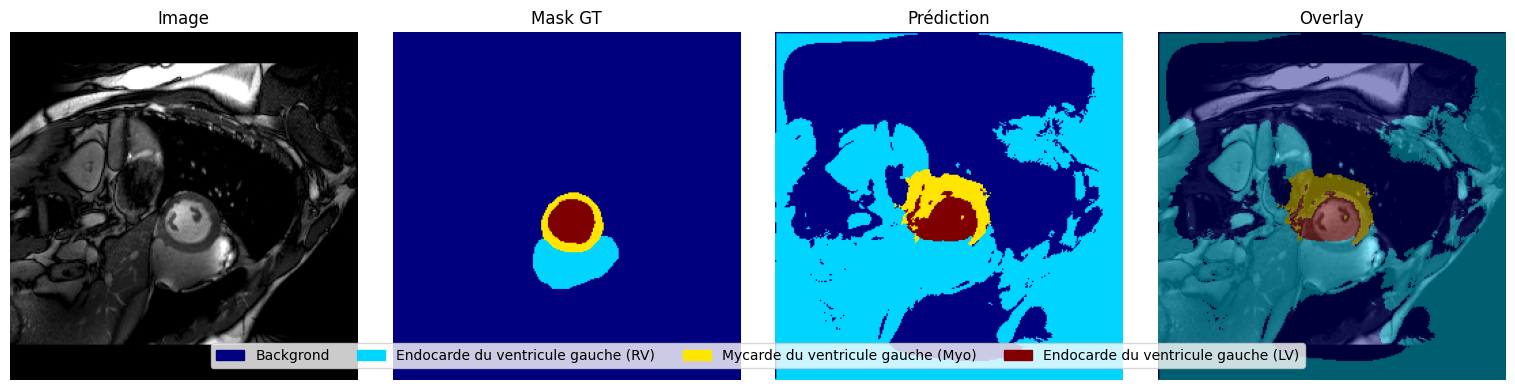

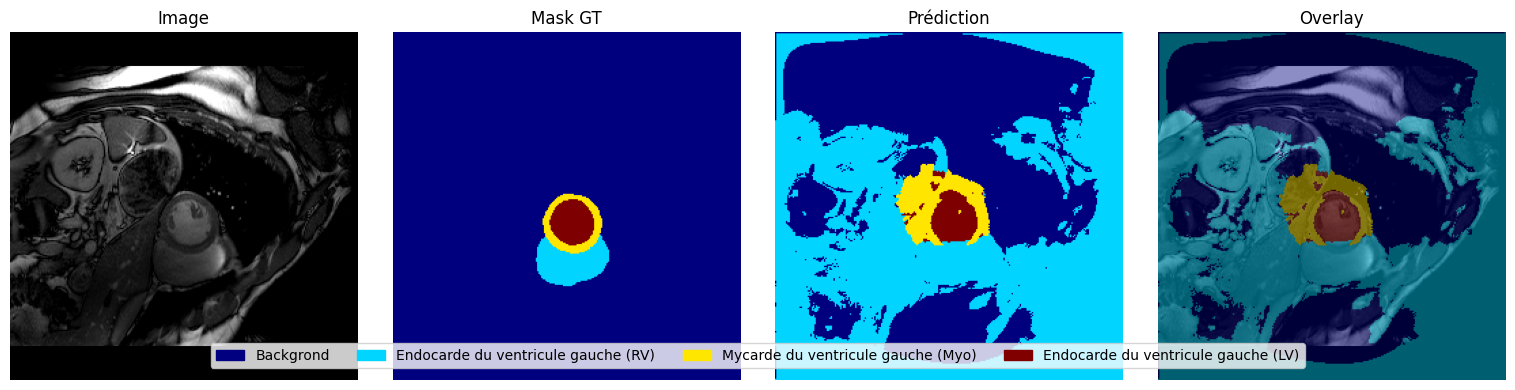

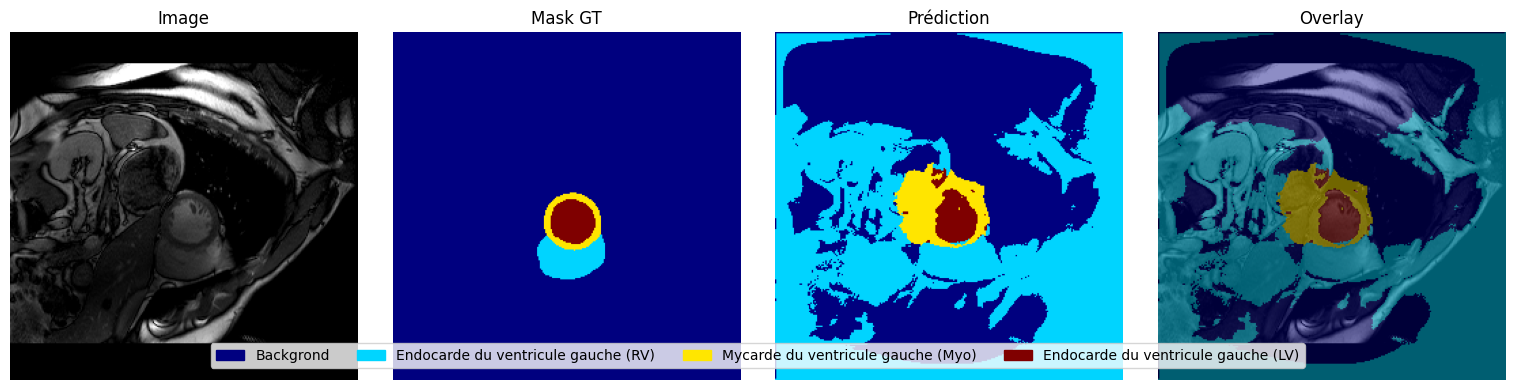

[Validation] Epoch: 0, Loss: 0.0486
           DICE : [0.63271646 0.06625068 0.27970539 0.83074683], mean = 0.4524
           ASD  : [39.18498468 40.04496195  6.02504339  4.6174768 ], mean = 22.4681
           HD   : [169.94531871 185.4397586   29.02648539  24.61033876], mean = 102.2555
--------------------------------------------------
Score Dice moyen         : 0.4524
HD95 moyen               : 104.5935
Composite (Dice+HD95)    : 0.2309
--------------------------------------------------
   >>> Nouveau record COMPOSITE ! (0.0000 -> 0.2309)
   Best composite saved at epoch 0.
   >>> Nouveau record LOSS ! (inf -> 0.0486)
   Best loss updated at epoch 0 (val_loss=0.0486)
   >>> Nouveau record DICE ! (0.0000 -> 0.4524)
   Best dice updated at epoch 0 (dice=0.4524)


[Training] Epoch: 1[DONE]                                                                                          
Epoch 1 terminée en 52.4s
 CE=0.6876 DiceL=0.7496 Bound=18.0498 TV=0.0000 Ramp=0.0082 Total=8.3133


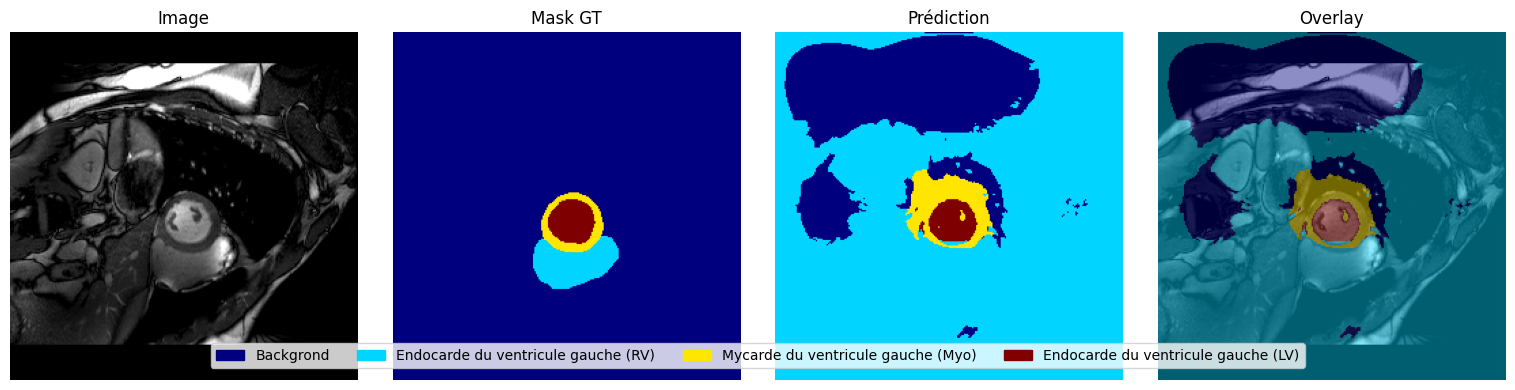

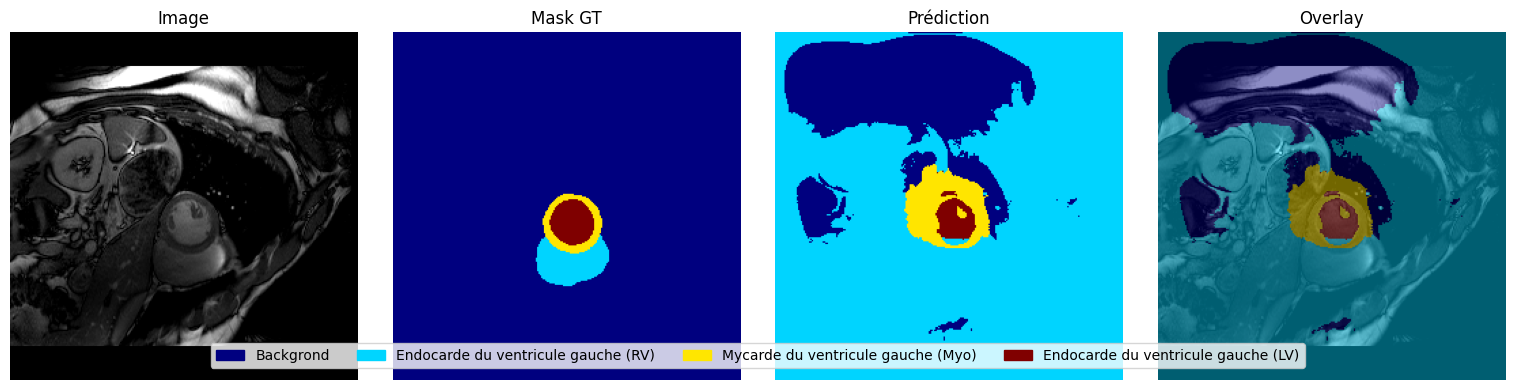

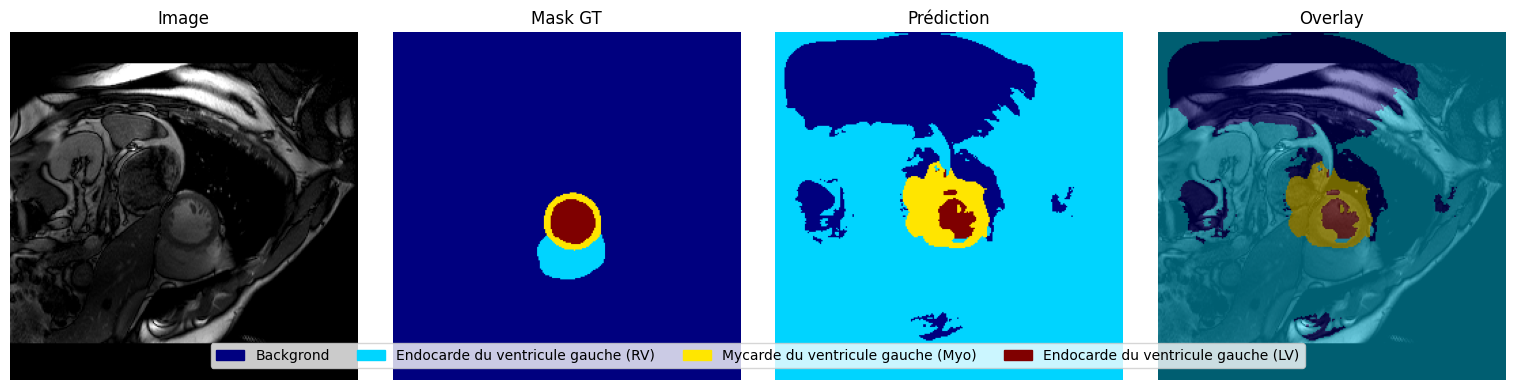

[Validation] Epoch: 1, Loss: 0.0474
           DICE : [0.36131692 0.04636637 0.37434067 0.79580305], mean = 0.3945
           ASD  : [43.34962512 44.06799126  5.16071232  3.39827006], mean = 23.9941
           HD   : [150.52701737 168.18735499  25.95799017  20.88347403], mean = 91.3890
--------------------------------------------------
Score Dice moyen         : 0.3945
HD95 moyen               : 93.7346
Composite (Dice+HD95)    : 0.2025
--------------------------------------------------
   >>> Nouveau record LOSS ! (0.0486 -> 0.0474)
   Best loss updated at epoch 1 (val_loss=0.0474)


[Training] Epoch: 2[=====>         ] 33.3% CE=1.0108 DiceL=0.8701 Bound=17.7211 TV=0.0000 Ramp=0.0100 Total=8.46397

In [ ]:
runTraining_combined_loss_test2(model_class=EnhancedUNet, loss_function=AdaptiveClassWeightedCombinedLoss, n_epochs=100)

### 5.2.0.5 FineTuning

In [ ]:
FineTuningRunTraining_Guided_(model_path=r"models\UNet_2_dope_Guided\loss_combined\191_Epoch.pt", model_class=UNet_2_dope,loss_function=FineTuningLoss, n_epochs=50, n_images=1, freeze_backbone=False
)

### 5.2.1 runTraining_Guided_deepsup_attention()

In [ ]:
runTraining_Guided_deepsup_attention(model_class=GuidedUNet, loss_function=CombinedLoss, n_epochs = 1, n_images=1, deep_supervision=True)

### 5.2.2 runTraining_Guided_deepsup_earlyfusion()

144
Création du UNet avec 5 canaux...

[Model Info] Architecture : LightSpeedUNet
[Model Info] Paramètres Totaux : 1,285,828
[Model Info] Paramètres Entraînables : 1,285,828
----------------------------------------

--- Démarrage de l'entraînement Guidé ---
DEBUG: main_output.shape = torch.Size([4, 4, 256, 256])
DEBUG: channel means: [-0.0772  0.039   0.2647 -0.2169]
DEBUG: channel stds:  [0.0017 0.0019 0.0018 0.0016]
DEBUG: pred unique classes: [2] counts: [262144]
DEBUG: sample_logits per-channel max: [-0.06611654  0.05541104  0.27070615 -0.19414273]
DEBUG: sample_logits per-channel min: [-0.09001273  0.0334185   0.24652596 -0.22050606]
[Training] Epoch: 0[>              ] 2.8% CE=1.5237 DiceL=0.9027 Bound=9.0659 Ramp=0.0067 Total=1.1911DEBUG: main_output.shape = torch.Size([4, 4, 256, 256])
DEBUG: channel means: [-0.0722  0.032   0.2563 -0.2194]
DEBUG: channel stds:  [0.0014 0.0009 0.0015 0.0022]
DEBUG: pred unique classes: [2] counts: [262144]
DEBUG: sample_logits per-channel max: 

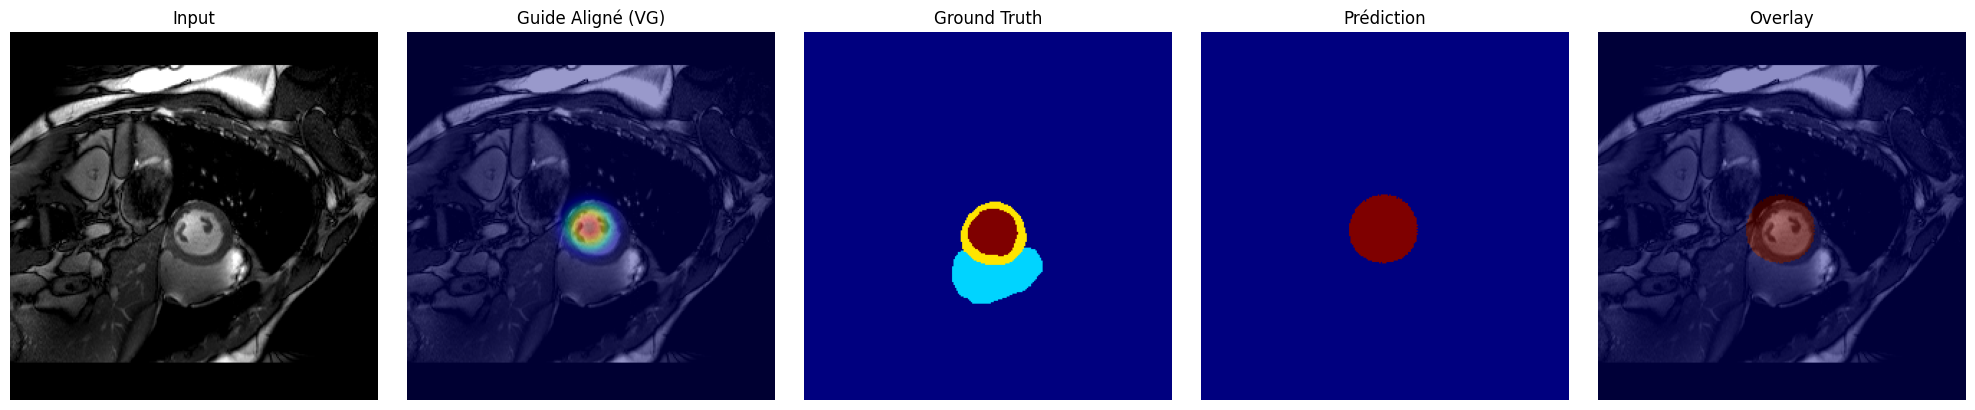

[Validation] Epoch: 0, Loss: 0.1466
           DICE : [0.98598485 0.         0.         0.64473978], mean = 0.4077
           ASD  : [9.67343788        nan        nan 6.98427854], mean = nan
           HD   : [24.39983603         nan         nan 14.16915873], mean = nan
--------------------------------------------------
Score Dice moyen         : 0.4077
HD95 moyen               : 21.7167
Composite (Dice+HD95)    : 0.2259
--------------------------------------------------
   >>> Nouveau record COMPOSITE ! (0.0000 -> 0.2259)
   Best composite saved at epoch 0.
   >>> Nouveau record LOSS ! (inf -> 0.1466)
   Best loss updated at epoch 0 (val_loss=0.1466)
   >>> Nouveau record DICE ! (0.0000 -> 0.4077)
   Best dice updated at epoch 0 (dice=0.4077)
DEBUG: main_output.shape = torch.Size([4, 4, 256, 256])
DEBUG: channel means: [ 3.8596 -2.5131 -2.3155  2.6624]
DEBUG: channel stds:  [1.5914 0.9763 1.0319 1.0454]
DEBUG: pred unique classes: [0 2 3] counts: [253356      4   8784]
DEBUG: sample_l

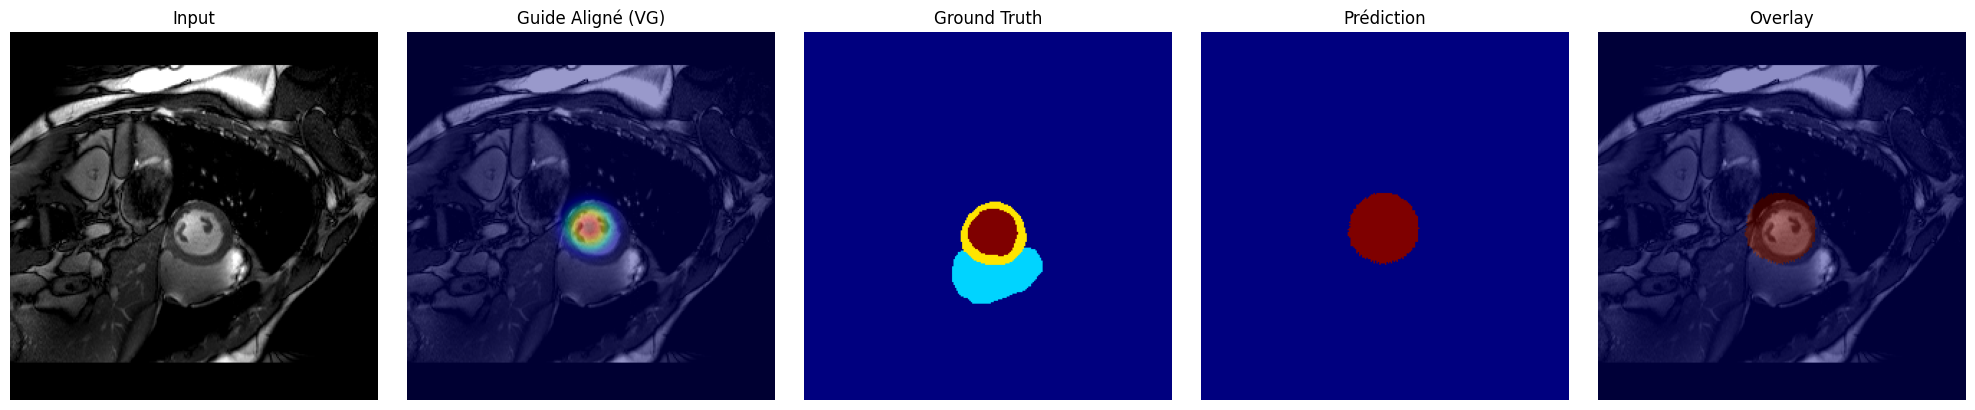

[Validation] Epoch: 1, Loss: 0.7908
           DICE : [0.98565985 0.         0.         0.61684837], mean = 0.4006
           ASD  : [9.74620436        nan        nan 7.66670834], mean = nan
           HD   : [23.58911288         nan         nan 15.02280211], mean = nan
--------------------------------------------------
Score Dice moyen         : 0.4006
HD95 moyen               : 21.8036
Composite (Dice+HD95)    : 0.2222
--------------------------------------------------
DEBUG: main_output.shape = torch.Size([4, 4, 256, 256])
DEBUG: channel means: [ 43.0141 -38.197  -34.6617  22.4558]
DEBUG: channel stds:  [12.998  11.2105 10.3073  6.3626]
DEBUG: pred unique classes: [0 3] counts: [254227   7917]
DEBUG: sample_logits per-channel max: [54.316704   -1.4038047  -0.77738845 29.696709  ]
DEBUG: sample_logits per-channel min: [ 1.8199688e+00 -4.7702888e+01 -4.6024284e+01  8.9627961e-03]
[Training] Epoch: 2[>              ] 2.8% CE=0.2675 DiceL=0.2346 Bound=21.8238 Ramp=0.0100 Total=0.2526DEB

KeyboardInterrupt: 

In [ ]:
runTraining_Guided_deepsup_earlyfusion(model_class=LightSpeedUNet, loss_function=CombinedLoss, n_epochs = 1, n_images=1, deep_supervision=True)

### 5.2.3 runTraining_combined_loss_deepsup()

In [ ]:
runTraining_combined_loss_deepsup(model_class=LightSpeedUNet, loss_function=CombinedLoss_with_TV, deep_supervision=True, n_epochs=1)

### 5.2.4 runTraining_Guided()

In [ ]:
# avec un guide et combinedloss_with_TV
runTraining_Guided(UNet_dope, CombinedLoss_with_TV)

### 5.2.5 Autres Tests

In [ ]:
# avec un guide et guidedcombinedloss
runTraining_Guided(UNet_2_dope, GuidedCombinedLoss, n_epochs=300)

In [ ]:
# Avec le loss standard
lossTotalTraining, val_loss_list, dice_list, asd_list, hd_list = runTraining(UNet)

class_names = ["BG", "RV", "Myo", "LV"]

plot_metrics_curves(
    loss_train=lossTotalTraining,
    loss_val=val_loss_list,
    dice_list=dice_list,
    hd_list=hd_list,
    asd_list=asd_list,
    class_names=class_names
)

In [ ]:
# Avec le loss classique
lossTotalTraining, val_loss_list, dice_list, asd_list, hd_list = runTraining_combined_loss(UNet)

class_names = ["BG", "RV", "Myo", "LV"]

plot_metrics_curves(
    loss_train=lossTotalTraining,
    loss_val=val_loss_list,
    dice_list=dice_list,
    hd_list=hd_list,
    asd_list=asd_list,
    class_names=class_names
)

In [ ]:
# Avec le loss combiné
lossTotalTraining, val_loss_list, dice_list, asd_list, hd_list = runTraining_combined_loss(UNet_2)

class_names = ["BG", "RV", "Myo", "LV"]

plot_metrics_curves(
    loss_train=lossTotalTraining,
    loss_val=val_loss_list,
    dice_list=dice_list,
    hd_list=hd_list,
    asd_list=asd_list,
    class_names=class_names
)

À chaque epoch, le modèle passe successivement par :

- une phase d'entraînement (LossG),
- une phase de validation (val_loss),
- une vérification si le modèle est le meilleur jusqu’ici.

Dans cette fonction, nous avons ajouté :
<p style="color:lightgreen">
- Une fonction pour évaluer le modèle à chaque epoch<br>
- Une fonction pour calculer le Dice score
</p>

La classe 0 correspond au background, la classe 1 au ventricule droit, la classe 2 à la myocarde, la classe 3 au ventricule gauche.
Score de base du modèle UNet : 
classe 1 -> 65-70%
classe 2 -> 75-80%
classe 3 -> 75-80%

# 5. - k-fold

## 5.1 Nouveau Data Loader

Data loader spécifiaque pour renvoyer une liste de tuples plutôt qu'une chaine de caratères

In [97]:
from torch.utils.data import Dataset
from PIL import Image, ImageOps
import os
import random

class KFoldMedicalDataset(Dataset):
    def __init__(self, file_list, transform=None, mask_transform=None, augment=False, equalize=False):
        """
        Dataset dédié au K-Fold qui prend une liste de fichiers explicite.
        Args:
            file_list (list): Liste de tuples [(img_path, mask_path), ...]
            transform: Transformation Tensor pour l'image
            mask_transform: Transformation Tensor pour le masque
            augment (bool): Si True, active quelques augmentations légères 'online' (flip/rotate)
            equalize (bool): Si True, égalise l'histogramme de l'image
        """
        self.file_list = file_list
        self.transform = transform
        self.mask_transform = mask_transform
        self.augment_status = augment
        self.equalize = equalize

    def __len__(self):
        return len(self.file_list)

    def augment_fn(self, img, mask):
        """Augmentation 'Online' légère (en plus de l'offline si besoin)"""
        # Flip Vertical (Rare en cardiaque mais possible)
        if random.random() > 0.5:
            img = ImageOps.flip(img)
            mask = ImageOps.flip(mask)
        # Flip Horizontal (Miroir)
        if random.random() > 0.5:
            img = ImageOps.mirror(img)
            mask = ImageOps.mirror(mask)
        # Rotation légère aléatoire (+/- 10 deg)
        if random.random() > 0.5:
            angle = random.random() * 20 - 10
            img = img.rotate(angle)
            mask = mask.rotate(angle)
        return img, mask

    def __getitem__(self, index):
        img_path, mask_path = self.file_list[index]
        
        try:
            img = Image.open(img_path)
            # Conversion masque en niveaux de gris (valeurs 0,1,2,3)
            mask = Image.open(mask_path).convert("L")
        except Exception as e:
            print(f"Erreur chargement : {img_path} ({e})")
            return None

        # Égalisation d'histogramme (Optionnel)
        if self.equalize:
            img = ImageOps.equalize(img)

        # Augmentation (Seulement si activée)
        if self.augment_status:
            img, mask = self.augment_fn(img, mask)

        # Transformations PyTorch (ToTensor)
        if self.transform:
            img = self.transform(img)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        # On retourne le nom du fichier pour le suivi
        file_name = os.path.basename(img_path)
        
        return img, mask, file_name

## 5.2 Split des images

In [98]:
import os
import numpy as np
from sklearn.model_selection import KFold

def get_kfold_split(data_dir, n_splits=4, current_fold=0, seed=42):
    """
    Separe les donnees par Patient.
    IMPORTANT : Pour la Validation, ne garde QUE les fichiers originaux (_orig).
    """
    img_dir = os.path.join(data_dir, 'Img')
    mask_dir = os.path.join(data_dir, 'GT')
    
    # Recuperer tous les fichiers images (ignorer les fichiers caches)
    all_files = sorted([f for f in os.listdir(img_dir) if not f.startswith('.')])
    
    # 1. Extraction des IDs Patients Uniques
    # Format suppose: patientXXX_...
    patient_ids = sorted(list(set([f.split('_')[0] for f in all_files])))
    
    print(f"[INFO] K-Fold: {len(patient_ids)} patients uniques trouves.")
    
    # 2. Creation du Split
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    splits = list(kf.split(patient_ids))
    
    train_indices, val_indices = splits[current_fold]
    
    # IDs des patients pour ce fold
    train_patients = [patient_ids[i] for i in train_indices]
    val_patients = [patient_ids[i] for i in val_indices]
    
    # 3. Repartition des fichiers
    train_list = []
    val_list = []
    
    for f in all_files:
        p_id = f.split('_')[0] # ex: patient001
        
        full_img_path = os.path.join(img_dir, f)
        full_mask_path = os.path.join(mask_dir, f)
        
        # CAS TRAIN : On prend TOUT (original + augmentations)
        if p_id in train_patients:
            train_list.append((full_img_path, full_mask_path))
            
        # CAS VAL : On ne prend QUE L'ORIGINAL
        elif p_id in val_patients:
            # Filtre strict : le fichier doit contenir "_orig"
            #if "_orig" in f: 
            val_list.append((full_img_path, full_mask_path))
            
    return train_list, val_list, train_patients, val_patients

## 5.3 Entrainement k-fold

### 5.3.1 Loss cross-entropie

In [99]:
import time
import os
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

# Import de la barre de progression (depuis votre fichier progressBar.py)
from progressBar import printProgressBar 

def run_kfold_experiment(
    data_dir='./Data_augment/PreAugmented_2', 
    n_folds=4, 
    model_class=UNet_2, 
    experiment_name="ACDC_Unet_Final",
    epochs=50,
    batch_size=4,
    lr=0.001
):
    
    # 1. Setup Device
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] Demarrage K-Fold sur : {device}")
    
    base_save_dir = os.path.join('./models', experiment_name)
    if not os.path.exists(base_save_dir):
        os.makedirs(base_save_dir)

    # --- BOUCLE SUR LES FOLDS ---
    for fold in range(n_folds):
        print(f"\n{'='*60}")
        print(f"FOLD {fold+1}/{n_folds}")
        print(f"{'='*60}")
        
        # A. Preparation des Donnees
        train_list, val_list, train_p, val_p = get_kfold_split(data_dir, n_splits=n_folds, current_fold=fold)
        
        print(f"   Train : {len(train_list)} images (Patients: {len(train_p)})")
        print(f"   Val   : {len(val_list)} images (Patients: {len(val_p)}) [ORIGINAUX SEULEMENT]")
        
        # B. Datasets & Loaders
        transform = transforms.Compose([transforms.ToTensor()])
        
        train_ds = KFoldMedicalDataset(train_list, transform=transform, mask_transform=transform, augment=True)
        val_ds = KFoldMedicalDataset(val_list, transform=transform, mask_transform=transform, augment=False)
        
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
        
        # C. Init Modele
        net = model_class(num_classes=4).to(device)
        class_weights = torch.tensor([0.1, 5, 5, 5], dtype=torch.float).to(device)
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(net.parameters(), lr=lr)
        
        # Dossier Fold
        fold_dir = os.path.join(base_save_dir, f"Fold_{fold}")
        if not os.path.exists(fold_dir):
            os.makedirs(fold_dir)
            
        best_val_loss = float('inf')
        best_metrics = {} 
        start_time_fold = time.time()
        
        # --- TRAINING LOOP (EPOCHS) ---
        for epoch in range(epochs):
            net.train()
            epoch_loss = 0
            num_batches = len(train_loader)
            
            # --- BOUCLE BATCHES AVEC PROGRESS BAR ---
            for j, batch in enumerate(train_loader):
                if batch is None: continue
                
                imgs, lbls, _ = batch
                imgs, lbls = imgs.to(device), lbls.to(device)
                
                optimizer.zero_grad()
                preds = net(imgs)
                target = getTargetSegmentation(lbls).to(device)
                
                loss = criterion(preds, target)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                
                # Mise a jour de la barre
                printProgressBar(j + 1, num_batches, 
                                 prefix=f"Fold {fold} Ep {epoch+1}/{epochs}", 
                                 length=20, 
                                 suffix=f"Loss: {loss.item():.4f}")
            
            # Validation
            val_loss, val_dice, val_metrics = validate_simple(
                net, val_loader, criterion, 4, device, show_graphics=False
            )
            
            # Affichage resume de l'epoque (ecrase la barre de progression ou s'affiche apres)
            print(f"   > Val Loss: {val_loss:.4f} | Dice: {np.mean(val_dice):.4f}")
            
            # Sauvegarde Best Model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_metrics = val_metrics
                torch.save(net.state_dict(), os.path.join(fold_dir, "best_model.pth"))
        
        # --- RAPPORT FIN DE FOLD ---
        duration = time.time() - start_time_fold
        report_path = os.path.join(fold_dir, "training_report.txt")
        
        with open(report_path, "w") as f:
            f.write(f"=== RAPPORT FOLD {fold} ===\n")
            f.write(f"Date: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Duree: {duration:.1f}s\n")
            f.write(f"Best Val Loss: {best_val_loss:.5f}\n")
            
            # Récupération des scores (ou liste de 0 si vide)
            dices = best_metrics.get('dice', [0, 0, 0, 0])
            asds = best_metrics.get('asd', [0, 0, 0, 0])
            hds = best_metrics.get('hd', [0, 0, 0, 0])
            
            # 1. Ecrire la moyenne globale
            f.write(f"Dice Moyen Global: {np.mean(dices):.4f}\n\n")
            
            # 2. Ecrire le détail par classe
            f.write("--- DETAIL PAR CLASSE ---\n")
            class_names = ["Fond", "RV (Ventr. Droit)", "Myo (Mycarde du ventr. gauche)", "LV (Ventr. Gauche)"]
            
            for i, name in enumerate(class_names):
                # Protection si jamais le tableau est plus petit que prévu
                d = dices[i] if i < len(dices) else 0
                a = asds[i] if i < len(asds) else 0
                h = hds[i] if i < len(hds) else 0
                
                f.write(f"Classe {i} ({name}):\n")
                f.write(f"   Dice : {d:.4f}\n")
                f.write(f"   ASD  : {a:.4f}\n")
                f.write(f"   HD   : {h:.4f}\n")
            
            f.write(f"\n--- PATIENTS ---\n")
            f.write(f"Patients Val: {val_p}\n")

    print("\n[INFO] Experience K-Fold terminee.")

### 5.3.2 Loss combined

In [100]:
def run_kfold_experiment_combined(
    data_dir='./Data_augment/PreAugmented_2', 
    n_folds=4, 
    model_class=UNet_2, 
    experiment_name="ACDC_Unet_Combined_Final",
    epochs=50,
    batch_size=4,
    lr=0.001
):
    
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] Demarrage K-Fold Combined sur : {device}")
    
    base_save_dir = os.path.join('./models', experiment_name)
    if not os.path.exists(base_save_dir):
        os.makedirs(base_save_dir)

    for fold in range(n_folds):
        print(f"\n{'='*60}")
        print(f"FOLD {fold+1}/{n_folds}")
        print(f"{'='*60}")
        
        train_list, val_list, train_p, val_p = get_kfold_split(data_dir, n_splits=n_folds, current_fold=fold)
        print(f"   Train : {len(train_list)} images (Patients: {len(train_p)})")
        print(f"   Val   : {len(val_list)} images (Patients: {len(val_p)}) [ORIGINAUX SEULEMENT]")
        
        
        transform = transforms.Compose([transforms.ToTensor()])
        train_ds = KFoldMedicalDataset(train_list, transform=transform, mask_transform=transform, augment=True)
        val_ds = KFoldMedicalDataset(val_list, transform=transform, mask_transform=transform, augment=False)
        
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
        
        net = model_class(num_classes=4).to(device)
        class_weights = torch.tensor([0.1, 5, 5, 5], dtype=torch.float).to(device)
        
        # Loss
        criterion_train = CombinedLoss(num_classes=4, weight=class_weights).to(device)
        criterion_val = torch.nn.CrossEntropyLoss(weight=class_weights).to(device)
        
        optimizer = optim.Adam(net.parameters(), lr=lr)
        
        fold_dir = os.path.join(base_save_dir, f"Fold_{fold}")
        if not os.path.exists(fold_dir):
            os.makedirs(fold_dir)
            
        best_val_loss = float('inf')
        best_metrics = {} 
        start_time_fold = time.time()
        
        for epoch in range(epochs):
            net.train()
            epoch_loss = 0
            num_batches = len(train_loader)
            
            for j, batch in enumerate(train_loader):
                if batch is None: continue
                
                imgs, lbls, _ = batch
                imgs, lbls = imgs.to(device), lbls.to(device)
                
                optimizer.zero_grad()
                preds = net(imgs)
                target = getTargetSegmentation(lbls).to(device)
                
                # --- CORRECTION ICI ---
                # On appelle compute_sdf_batch_gpu avec SEULEMENT 2 arguments (comme défini actuellement)
                # Le résultat est probablement un tenseur sur CPU ou GPU selon la fonction
                target_sdf = compute_sdf_batch_gpu(target, 4)
                
                # On s'assure que le résultat est bien sur le bon device pour la suite
                target_sdf = target_sdf.to(device)
                
                # Suite normale
                loss, ce_val, dice_val, bound_val, ramp = criterion_train(preds, target, target_sdf, epoch)
                
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                
                suffix_str = f"Tot:{loss.item():.2f} C:{ce_val.item():.2f} D:{dice_val.item():.2f} B:{bound_val.item():.2f}"
                printProgressBar(j + 1, num_batches, 
                                 prefix=f"Fold {fold} Ep {epoch+1}/{epochs}", 
                                 length=15, 
                                 suffix=suffix_str)
            
            val_loss, val_dice, val_metrics = validate_simple(
                net, val_loader, criterion_val, 4, device, show_graphics=False
            )
            
            dice_moyen = np.mean(val_dice)
            print(f"   > Val Loss (CE): {val_loss:.4f} | Dice Moy: {dice_moyen:.4f}")
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_metrics = val_metrics
                torch.save(net.state_dict(), os.path.join(fold_dir, "best_model.pth"))
        
        duration = time.time() - start_time_fold
        report_path = os.path.join(fold_dir, "training_report.txt")
        
        with open(report_path, "w") as f:
            f.write(f"=== RAPPORT FOLD {fold} ===\n")
            f.write(f"Date: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Duree: {duration:.1f}s\n")
            f.write(f"Best Val Loss (CE): {best_val_loss:.5f}\n")
            
            dices = best_metrics.get('dice', [0, 0, 0, 0])
            asds = best_metrics.get('asd', [0, 0, 0, 0])
            hds = best_metrics.get('hd', [0, 0, 0, 0])
            
            f.write(f"Dice Moyen Global: {np.mean(dices):.4f}\n\n")
            f.write("--- DETAIL PAR CLASSE ---\n")
            class_names = ["Fond", "RV", "Myo", "LV"]
            
            for i, name in enumerate(class_names):
                d = dices[i] if i < len(dices) else 0
                a = asds[i] if i < len(asds) else 0
                h = hds[i] if i < len(hds) else 0
                f.write(f"Classe {i} ({name}):\n   Dice : {d:.4f}\n   ASD  : {a:.4f}\n   HD   : {h:.4f}\n")
            
            f.write(f"\n--- PATIENTS ---\nPatients Val: {val_p}\n")

    print("\n[INFO] Experience K-Fold terminee.")

In [101]:
# Lance la validation croisée sur 4 folds
run_kfold_experiment(
    data_dir='./Data_augment/PreAugmented_3', # Ou votre dossier de données
    n_folds=4,
    experiment_name="Unet_2_preaugm3_kfold",
    epochs=50 # Mettez le nombre que vous voulez
)

[INFO] Demarrage K-Fold sur : cpu

FOLD 1/4


FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: './Data_augment/PreAugmented_3\\Img'

In [102]:
run_kfold_experiment_combined(
    #data_dir='./Data_augment_no/train',
    #data_dir='./Data/train_complete',
    n_folds=4,
    model_class=UNet_2,
    experiment_name="Unet_2_kfold_combined",
    epochs=70,
    batch_size=4,
    lr=0.001
)

[INFO] Demarrage K-Fold Combined sur : cpu

FOLD 1/4
[INFO] K-Fold: 12 patients uniques trouves.
   Train : 608 images (Patients: 9)
   Val   : 208 images (Patients: 3) [ORIGINAUX SEULEMENT]


TypeError: compute_sdf_batch_gpu() missing 1 required positional argument: 'device'

# 6. Entrainement Semi-supervisé

## 6.1. Récupération des images non labelisées

In [105]:
# ! pip install tqdm
from tqdm import tqdm
def get_unlabeled_files(root_dir='./Data/unlabeled'):
    """Récupère la liste des images non annotées."""
    img_dir = os.path.join(root_dir, 'Img-Unlabeled')
    if not os.path.exists(img_dir):
        print(f" Attention : Dossier {img_dir} introuvable.")
        return []
        
    files = sorted([f for f in os.listdir(img_dir) if not f.startswith('.')])
    
    # Retourne une liste de tuples (chemin_img, None) car pas de masque
    file_list = []
    for f in files:
        full_path = os.path.join(img_dir, f)
        file_list.append(full_path)
        
    print(f" {len(file_list)} images non annotées trouvées.")
    return file_list

# Classe Dataset simplifiée pour l'inférence (pas de masque)
class UnlabeledDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index]
        try:
            img = Image.open(img_path)
        except:
            return None
            
        if self.transform:
            img = self.transform(img)
            
        # On renvoie l'image et son nom pour la sauvegarde
        return img, os.path.basename(img_path)

## 6.2. Génération des pseudo-labels

In [123]:
from tqdm import tqdm # Import essentiel

# --- 1. Récupération des fichiers ---
def get_unlabeled_files(root_dir):
    """
    Récupère la liste des images non annotées.
    Suppose que les images sont dans : root_dir/Img-Unlabeled
    """
    # Attention : Vous avez spécifié 'Img-Unlabeled' ici.
    # Assurez-vous que ce dossier existe bien dans ./Data/train/Img-Unlabeled
    img_dir = os.path.join(root_dir, 'Img-Unlabeled')
    
    if not os.path.exists(img_dir):
        # Fallback : Si Img-Unlabeled n'existe pas, on essaie d'autres noms classiques
        alternatives = ['unlabeled', 'Img', 'images']
        found = False
        for alt in alternatives:
            test_dir = os.path.join(root_dir, alt)
            if os.path.exists(test_dir):
                print(f" Dossier 'Img-Unlabeled' non trouvé. Utilisation de '{alt}' à la place.")
                img_dir = test_dir
                found = True
                break
        
        if not found:
            print(f" Erreur : Impossible de trouver un dossier d'images dans {root_dir}")
            return []
        
    files = sorted([f for f in os.listdir(img_dir) if not f.startswith('.')])
    
    file_list = []
    for f in files:
        full_path = os.path.join(img_dir, f)
        file_list.append(full_path)
        
    print(f" {len(file_list)} images non annotées trouvées dans {img_dir}")
    return file_list

# --- 2. Dataset ---
class UnlabeledDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index]
        try:
            img = Image.open(img_path)
        except Exception as e:
            print(f"Erreur lecture {img_path}: {e}")
            return None
            
        if self.transform:
            img = self.transform(img)
            
        return img, os.path.basename(img_path)

# --- 3. Génération ---
def generate_pseudo_labels(
    model_path,          
    data_dir='./Data',   
    output_dir='./Data/PseudoLabeled', 
    model_class=UNet_2,
    device=torch.device("mps" if torch.backends.mps.is_available() else "cpu"),
    masque = True,
    locator = None
):
    print(f" Génération des Pseudo-Labels avec : {os.path.basename(model_path)}")
    
    # Création des dossiers de sortie
    os.makedirs(os.path.join(output_dir, 'Img'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'GT'), exist_ok=True)
    
    # Chargement du modèle (Méthode Robuste pour Mac/MPS)
    net = model_class(num_classes=4).to(device)
    
    try:
        # On force le chargement sur CPU d'abord pour éviter les bugs de pickle MPS
        state_dict = torch.load(model_path, map_location="cpu", weights_only=False)
        net.load_state_dict(state_dict)
    except Exception as e:
        print(f" Erreur chargement modèle : {e}")
        return

    net.to(device)
    net.eval()
    
    # Loader Unlabeled
    # CORRECTION ICI : on passe data_dir directement, pas os.path(data_dir)
    unlabeled_files = get_unlabeled_files(data_dir)
    
    if not unlabeled_files:
        print("Arrêt : Pas d'images trouvées.")
        return

    dataset = UnlabeledDataset(unlabeled_files, transform=transforms.ToTensor())
    loader = DataLoader(dataset, batch_size=1, shuffle=False)


    if masque:
        locator = ComplexHeartLocator().to(device)
        path_locator = './Results/Models/best_heart_locator.pt'
        if not os.path.exists(path_locator): path_locator = './Results/Models/heart_locator.pt'
        locator.load_state_dict(torch.load(path_locator))
        locator.eval()

        guide_path = './Results/GuideMasks/guide_masks_probabilistic.npy'
        guide_np = np.load(guide_path).astype(np.float32)
        guide_tensor = torch.from_numpy(guide_np).to(device)
    
    # Inférence
    count = 0
    print(f"   Démarrage de l'inférence...")
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Pseudo-Labeling"):
            if batch is None: continue # Gestion erreurs lecture
            
            img, filename = batch
            img = img.to(device)
            filename = filename[0] 

            if masque :
                images = img
                # --- A. GUIDAGE ---
                offsets = locator(images)
                H, W = images.shape[2], images.shape[3]
                aligned_guides = shift_batch_on_gpu(guide_tensor, offsets, H, W)
                
                # --- B. FUSION ---
                inputs = torch.cat([images, aligned_guides], dim=1)

                # --- C. PRÉDICTION ---
                output = net(inputs)
            else:
                output = net(img) 

            # Prédiction
            pred_mask = torch.argmax(output, dim=1).squeeze() 
            pred_mask_np = pred_mask.cpu().numpy().astype(np.uint8)
            
            # --- CORRECTION MAJEURE ICI ---
            # Conversion 0-3 vers 0-255 pour matcher le format ACDC
            pred_mask_scaled = pred_mask_np * 85
            
            # Sauvegarde
            
            # 1. Image Originale
            # img est [1, C, H, W], on squeeze seulement la dim batch pour garder [C, H, W]
            orig_img_pil = transforms.ToPILImage()(img.cpu().squeeze(0))
            orig_img_pil.save(os.path.join(output_dir, 'Img', filename))
            
            # 2. Masque (GT)
            # UTILISER LA VERSION SCALÉE (0-255) ICI !
            # mode='L' assure que c'est sauvegardé en niveaux de gris 8-bits
            mask_pil = Image.fromarray(pred_mask_scaled, mode='L')
            mask_pil.save(os.path.join(output_dir, 'GT', filename))
            
            count += 1
            
    print(f" Terminé ! {count} paires générées dans {output_dir}")

## 6.3. Inférences

In [124]:
# Exemple d'utilisation
best_model_path = "./models/UNet_2_dope_Guided_FineTuned/fine_tuned/Best_Composite_Score.pt" # À adapter

# pour utiliser les masques guides :
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

generate_pseudo_labels(
    model_class = UNet_2_dope,
    model_path=best_model_path,
    data_dir='./Data/train',
    output_dir='./Data/PseudoLabeled_v1',
    masque=true

)

 Génération des Pseudo-Labels avec : Best_Composite_Score.pt
 1004 images non annotées trouvées dans ./Data/train\Img-Unlabeled
   Démarrage de l'inférence...


Pseudo-Labeling: 100%|██████████| 1004/1004 [07:43<00:00,  2.17it/s]

 Terminé ! 1004 paires générées dans ./Data/PseudoLabeled_v1


### 6.3.1 Vérification des données générées

🔍 Analyse de 5 masques aléatoires sur 1004 fichiers...

 patient048_08_6.png
   - Valeurs uniques : [  0  85 170 255]
   - Min: 0, Max: 255
   - Remplissage : 2.22% (1452 pixels)
 Contient des prédictions
------------------------------
 patient029_01_7.png
   - Valeurs uniques : [  0  85 170 255]
   - Min: 0, Max: 255
   - Remplissage : 3.33% (2180 pixels)
 Contient des prédictions
------------------------------
 patient059_01_9.png
   - Valeurs uniques : [  0  85 170 255]
   - Min: 0, Max: 255
   - Remplissage : 0.48% (315 pixels)
 Contient des prédictions
------------------------------
 patient074_01_1.png
   - Valeurs uniques : [  0  85 170 255]
   - Min: 0, Max: 255
   - Remplissage : 4.39% (2877 pixels)
 Contient des prédictions
------------------------------
 patient088_12_13.png
   - Valeurs uniques : [  0  85 170 255]
   - Min: 0, Max: 255
   - Remplissage : 0.92% (601 pixels)
 Contient des prédictions
------------------------------

 Résultat : 0/5 masques analysés sont totale

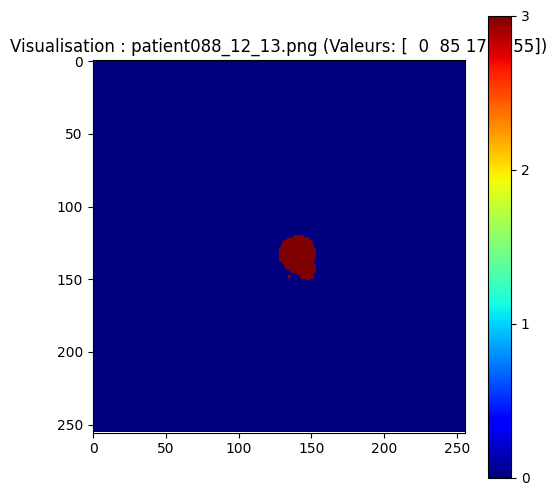

In [125]:
import os
import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt

def analyze_pseudo_labels(pseudo_dir='./Data/PseudoLabeled_v1/GT', n_samples=5):
    """
    Analyse statistique rapide des masques générés pour vérifier s'ils sont vides.
    """
    if not os.path.exists(pseudo_dir):
        print(f" Dossier introuvable : {pseudo_dir}")
        return

    files = sorted([f for f in os.listdir(pseudo_dir) if not f.startswith('.')])
    
    if not files:
        print(" Le dossier est vide.")
        return

    print(f"🔍 Analyse de {n_samples} masques aléatoires sur {len(files)} fichiers...\n")
    
    # Sélection aléatoire
    samples = random.sample(files, min(n_samples, len(files)))
    
    count_empty = 0
    
    for f in samples:
        path = os.path.join(pseudo_dir, f)
        
        # Chargement sans conversion pour voir les vraies valeurs brutes
        mask = Image.open(path)
        mask_np = np.array(mask)
        
        # Statistiques
        unique_vals = np.unique(mask_np)
        pixel_sum = np.sum(mask_np)
        non_zero_pixels = np.count_nonzero(mask_np)
        total_pixels = mask_np.size
        fill_ratio = (non_zero_pixels / total_pixels) * 100
        
        print(f" {f}")
        print(f"   - Valeurs uniques : {unique_vals}")
        print(f"   - Min: {mask_np.min()}, Max: {mask_np.max()}")
        print(f"   - Remplissage : {fill_ratio:.2f}% ({non_zero_pixels} pixels)")
        
        if len(unique_vals) == 1 and unique_vals[0] == 0:
            print("   ⚠️ MASQUE 100% VIDE (Noir)")
            count_empty += 1
        else:
            print(" Contient des prédictions")
            
        print("-" * 30)

    print(f"\n Résultat : {count_empty}/{len(samples)} masques analysés sont totalement vides.")
    
    # Affichage visuel du dernier échantillon pour confirmer
    if 'mask_np' in locals():
        plt.figure(figsize=(6, 6))
        # On utilise une colormap 'jet' ou 'tab10' pour bien voir les classes 1, 2, 3 même si elles sont sombres
        plt.imshow(mask_np, cmap='jet', vmin=0, vmax=3, interpolation='nearest')
        plt.title(f"Visualisation : {f} (Valeurs: {unique_vals})")
        plt.colorbar(ticks=[0, 1, 2, 3])
        plt.show()

# Lancer l'analyse
analyze_pseudo_labels(pseudo_dir='./Data/PseudoLabeled_v1/GT')

## 6.4 Entrainement semi-supervisé

In [149]:
def run_semisupervised_experiment(
    labeled_dir='./Data/train',            
    pseudo_dir='./Data/PseudoLabeled_v1', 
    n_folds=4,
    model_class=UNet_2,
    experiment_name="ACDC_SemiSupervised_Final",
    epochs=50,
    batch_size=4,
    lr=0.001,
    # --- NOUVEAUX PARAMÈTRES SCHEDULER ---
    lr_milestones=[30, 50], # A quelles époques on baisse le LR
    lr_gamma=0.2            # Par combien on multiplie (0.2 = diviser par 5)
):
    
    modelName = model_class.__name__
    Best_loss_val = float('inf')
    Best_dice_val = 0.0
    Best_Composite_Val = 0


    # 1. Setup Device
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    print(f"[SSL] Démarrage Semi-Supervisé sur : {device}")
    print(f"[SSL] Augmentation : DÉSACTIVÉE")
    print(f"[SSL] Scheduler : Milestones={lr_milestones}, Gamma={lr_gamma}")
    
    base_save_dir = os.path.join('./models', experiment_name)
    if not os.path.exists(base_save_dir):
        os.makedirs(base_save_dir)

    # 2. Préparation des Pseudo-Labels
    print(f"[SSL] Chargement des pseudo-labels depuis {pseudo_dir}...")
    pseudo_img_dir = os.path.join(pseudo_dir, 'Img')
    pseudo_gt_dir = os.path.join(pseudo_dir, 'GT')
    
    if not os.path.exists(pseudo_img_dir):
        print(f" Erreur: Dossier {pseudo_img_dir} introuvable.")
        return

    pseudo_files = sorted([f for f in os.listdir(pseudo_img_dir) if not f.startswith('.')])
    pseudo_list = []
    for f in pseudo_files:
        pseudo_list.append((os.path.join(pseudo_img_dir, f), os.path.join(pseudo_gt_dir, f)))
    
    print(f" {len(pseudo_list)} images pseudo-labelisées prêtes à être injectées.")

    # --- BOUCLE SUR LES FOLDS ---
    for fold in range(n_folds):
        print(f"\n{'='*60}")
        print(f"FOLD {fold+1}/{n_folds} (Semi-Supervisé)")
        print(f"{'='*60}")
        
        # A. Split des données
        train_list_real, val_list_real, train_p, val_p = get_kfold_split(labeled_dir, n_splits=n_folds, current_fold=fold)
        train_list_total = train_list_real + pseudo_list
        
        print(f"   Train : {len(train_list_real)} réelles + {len(pseudo_list)} pseudos = {len(train_list_total)} total")
        print(f"   Val   : {len(val_list_real)} réelles (Pure)")
        
        # B. Datasets & Loaders
        transform = transforms.Compose([transforms.ToTensor()])
        train_ds = KFoldMedicalDataset(train_list_total, transform=transform, mask_transform=transform, augment=False)
        val_ds = KFoldMedicalDataset(val_list_real, transform=transform, mask_transform=transform, augment=False)
        
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
        
        # C. Init Modèle & Optimiseur
        net = model_class(num_classes=4).to(device)
        class_weights = torch.tensor([0.1, 5, 5, 5], dtype=torch.float).to(device)
        
        criterion_train = CombinedLoss(num_classes=4, weight=class_weights).to(device)
        criterion_val = torch.nn.CrossEntropyLoss(weight=class_weights).to(device)
        
        optimizer = optim.Adam(net.parameters(), lr=lr)
        
        # --- SCHEDULER PARAMÉTRÉ ---
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_milestones, gamma=lr_gamma)
        
        fold_dir = os.path.join(base_save_dir, f"Fold_{fold}")
        if not os.path.exists(fold_dir): os.makedirs(fold_dir)
            
        best_val_loss = float('inf')
        best_metrics = {} 
        start_time_fold = time.time()
        
        # --- TRAINING LOOP ---
        for epoch in range(epochs):
            net.train()
            epoch_loss = 0
            num_batches = len(train_loader)
            current_lr = scheduler.get_last_lr()[0] # Pour l'affichage
            
            for j, batch in enumerate(train_loader):
                if batch is None: continue
                imgs, lbls, _ = batch
                imgs, lbls = imgs.to(device), lbls.to(device)
                
                optimizer.zero_grad()
                
                preds = net(imgs)
                target = getTargetSegmentation(lbls).to(device)
                
                # Calcul SDF
                try:
                    target_sdf = compute_sdf_batch_gpu(target, 4, device)
                except TypeError:
                    target_sdf = compute_sdf_batch_gpu(target, 4).to(device)
                
                loss, ce, dice, bound, ramp = criterion_train(preds, target, target_sdf, epoch)
                
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                
                if j % 50 == 0 or j == num_batches - 1:
                    suffix = f"L:{loss.item():.2f} (C:{ce.item():.1f}) LR:{current_lr:.1e}"
                    printProgressBar(j + 1, num_batches, prefix=f"F{fold} Ep{epoch+1}", length=15, suffix=suffix)
            
            # Mise à jour du LR à la fin de l'époque
            scheduler.step()

            # Validation
            val_loss, val_dice, m = validate_simple(net, val_loader, criterion_val, 4, device, show_graphics= True, n_images=10)
            
            print(f"[Validation] Epoch: {epoch}, Loss: {val_loss:.4f}")
            print(f"           DICE : {m['dice']}, mean = {np.mean(m['dice']):.4f}")
            print(f"           ASD  : {m['asd']}, mean = {np.mean(m['asd']):.4f}")
            print(f"           HD   : {m['hd']}, mean = {np.mean(m['hd']):.4f}")

            print("-" * 50)
            print(f"Score Dice moyen         : {m['dice_macro']:.4f}")
            print(f"HD95 moyen               : {m['hd95_macro']:.4f}")
            print(f"Composite (Dice+HD95)    : {m['composite']:.4f}")
            print("-" * 50)

            # --- CHECKPOINTING (Sauvegarde du meilleur modèle) ---

            model_dir = f'./models/{modelName}/semi_sup'
            if not os.path.exists(model_dir):
                
                os.makedirs(model_dir)

            composite_score = m["composite"]
            mean_dice = np.mean(m['dice'])

            if composite_score > Best_Composite_Val:
                print(f"   >>> Nouveau record COMPOSITE ! ({Best_Composite_Val:.4f} -> {composite_score:.4f})")
                Best_Composite_Val = composite_score
                torch.save(net.state_dict(), os.path.join(model_dir, 'Best_Composite_Score.pt'))
                print(f"   Best composite saved at epoch {epoch}.")

            if val_loss < Best_loss_val:
                print(f"   >>> Nouveau record LOSS ! ({Best_loss_val:.4f} -> {val_loss:.4f})")
                Best_loss_val = val_loss
                BestEpoch = epoch 
                torch.save(net.state_dict(), os.path.join(model_dir, f'{epoch}_Epoch_BestLoss.pt'))
                print(f"   Best loss updated at epoch {epoch} (val_loss={val_loss:.4f})")

            # --- 3. CRITÈRE MEAN DICE (MAXIMISATION) ---
            if mean_dice > Best_dice_val:
                print(f"   >>> Nouveau record DICE ! ({Best_dice_val:.4f} -> {mean_dice:.4f})")
                Best_dice_val = mean_dice
                torch.save(net.state_dict(), os.path.join(model_dir, 'Best_Model_Dice.pt'))
                print(f"   Best dice updated at epoch {epoch} (dice={Best_dice_val:.4f})")
            print("\n==========================================================================================\n")
        
        # --- RAPPORT FIN DE FOLD ---
        duration = time.time() - start_time_fold
        
        report_path = os.path.join(fold_dir, "training_report.txt")
        
        with open(report_path, "w") as f:
            f.write(f"=== RAPPORT FOLD {fold} (SSL) ===\n")
            f.write(f"Date: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Duree: {duration:.1f}s\n")
            f.write(f"Best Val Loss (CE): {best_val_loss:.5f}\n")
            f.write(f"Learning Rate Init: {lr}\n")
            f.write(f"Scheduler Milestones: {lr_milestones}, Gamma: {lr_gamma}\n\n") # On note les params
            
            d_list = best_metrics.get('dice', [0])
            d_global = np.mean(d_list) if isinstance(d_list, (list, np.ndarray)) else d_list
            f.write(f"Dice Global: {d_global:.4f}\n\n")
            
            f.write("--- DETAIL CLASSES ---\n")
            classes = ["Fond", "RV", "Myo", "LV"]
            dices = best_metrics.get('dice', [0]*4)
            asds = best_metrics.get('asd', [0]*4)
            hds = best_metrics.get('hd', [0]*4)
            
            if isinstance(dices, (list, np.ndarray)):
                for i, c in enumerate(classes):
                    d = dices[i] if i < len(dices) else 0
                    a = asds[i] if i < len(asds) else 0
                    h = hds[i] if i < len(hds) else 0
                    f.write(f"Classe {i} ({c}):\n")
                    f.write(f"   Dice : {d:.4f}\n")
                    f.write(f"   ASD  : {a:.4f}\n")
                    f.write(f"   HD   : {h:.4f}\n")
            
            f.write(f"\n--- PATIENTS ---\nPatients Val: {val_p}\n")
            
        print(f" Fold {fold} terminé.")

    print("\n[SSL] Expérience terminée.")

In [ ]:
# Exemple : Diviser par 5 à l'époque 30, puis encore par 5 à l'époque 50
run_semisupervised_experiment(
    model_class=UNet,
    labeled_dir='./Data/train_complete',
    pseudo_dir='./Data/PseudoLabeled_v1',
    n_folds=4,
    experiment_name="ACDC_SSL_Final_Test",
    epochs=60,          # On pousse à 60 pour profiter du 2eme palier
    batch_size=4,
    lr=0.007,           # LR Initial
    lr_milestones=[20, 35, 50], # Paliers
    lr_gamma=0.2        # Facteur (diviser par 5)
)

On observe que la perte d’entraînement reste stable autour de 1.07 pour toutes les époques :
- Cela indique que le modèle baseline apprend très peu, ou pas du tout.
- Le modèle apprend un peu au début (jusqu'à epoch : 6), puis commence à stagner ou légèrement sur-apprendre
- Meilleur modèle = epoch 6

A faire ensuite :
- Améliore le modèle
- faire un dice score
- visualiser les différentes étapes/prédictions